In [1]:
# Load packages
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns

In [30]:
refdata_type = "ATAC" # "RNA"
data = pd.read_csv("data/ranks/" + "Ranks_" + refdata_type + "cell_type.csv")
compartment_map = pd.read_csv("/data/compartments/compartment_map.csv")

sample             status      tfx gender              cell_type  correlation  rank
0      EE88247        Lung Cancer  0.06508      M                   Mast    -0.280656     1
1      EE88247        Lung Cancer  0.06508      M  T.lymphocyte.2..CD4..    -0.276613     2
2      EE88247        Lung Cancer  0.06508      M       Natural.Killer.T    -0.276276     3
3      EE88247        Lung Cancer  0.06508      M  T.Lymphocyte.1..CD8..    -0.274458     4
4      EE88247        Lung Cancer  0.06508      M                Naive.T    -0.271145     5
...        ...                ...      ...    ...                    ...          ...   ...
57493  EE87867  Colorectal Cancer  0.02104      M        Oligo.Precursor    -0.127926   107
57494  EE87867  Colorectal Cancer  0.02104      M                 GABA.1    -0.125991   108
57495  EE87867  Colorectal Cancer  0.02104      M        Glutamatergic.2    -0.122824   109
57496  EE87867  Colorectal Cancer  0.02104      M        Glutamatergic.1    -0.116171   110
57497  EE87867  Colorectal Cancer  0.02104      M            Astrocyte.2    -0.096406   111

[57498 rows x 7 columns]

In [31]:
# number of unqiue cell_type
len(data['cell_type'].unique())

111

In [32]:
## outliers
# remove EE87821 (breast cancer) and EE88267 (ovarian cancer) bc too high tfx, around 0.35
# and remove EE87787 bile duct cancer having tfx of 0.068 
# List of EE numbers to exclude
exclude_numbers = ["EE87821", "EE88267", "EE87787"]

# Filter out rows where 'sample' column matches the excluded values
data = data[~data["sample"].isin(exclude_numbers)]

In [34]:
cancer_types = list(data["status"].unique())
cancer_types.remove('Healthy')

['Lung Cancer', 'Breast Cancer', 'Pancreatic Cancer', 'Ovarian Cancer', 'Bile Duct Cancer', 'Colorectal Cancer', 'Gastric cancer']


In [35]:
# correlation using ranks
dic = {}
for cancer_type in cancer_types:
    # print(cancer_type)
    gender = data[data["status"] == cancer_type]["gender"].unique()
    subset_data = data[(data['status'].isin(["Healthy", cancer_type])) & (data['gender'].isin(gender))]

    # Initialize an empty list to store results
    subdic = {}

    for cell_type_oi in set(subset_data["cell_type"]):
        # print(cell_type_oi)
        subsub= subset_data[subset_data["cell_type"]==cell_type_oi]
        # take inverted rank for PCC calculation
        subsub_copy = subsub.copy()
        subsub_copy['inverted_ranks'] = len(data["cell_type"].unique()) - subsub['rank'] # 447 - rank
        # Calculate PCC and p-value
        pcc_inv, p_value = stats.pearsonr(subsub_copy['tfx'], subsub_copy['inverted_ranks'])
        subdic[cell_type_oi] = {'PCC': pcc_inv, 'p_value': p_value, 'df':subsub}

    dic[cancer_type] = subdic

Done.


In [36]:
# take for each cancer type the cells having top 10 lowest and highest PCC values for plotting
plot_dic = {}

for cancer_type in dic.keys():
    sub_dic = dic[cancer_type]
    
    # Extract all 'PCC' values along with their respective cell types
    pcc_values = [(cell_type, v['PCC']) for cell_type, v in dic[cancer_type].items()]

    # Sort the list by PCC value in descending order
    sorted_pcc = sorted(pcc_values, key=lambda x: x[1], reverse=True)

    # Get the top 10 highest PCC values and their associated cell types
    top_10_highest_pcc = sorted_pcc[:10]

    # Get the top 10 lowest PCC values and their associated cell types (reverse the sorting order)
    top_10_lowest_pcc = sorted_pcc[-10:]#[::-1] for reversed order
    
    cells_lowest_highest_pcc = (top_10_highest_pcc+top_10_lowest_pcc)
    # Extract the cell types from the list
    cell_types_to_select = [cell for cell, pcc in cells_lowest_highest_pcc]

    # Filter the sub-dictionary to include only the selected cells
    filtered_cancer_subdic = {cell_type: sub_dic[cell_type] 
                                         for cell_type in cell_types_to_select 
                                         if cell_type in sub_dic}
    plot_dic[cancer_type] = filtered_cancer_subdic

atac
Lung Cancer


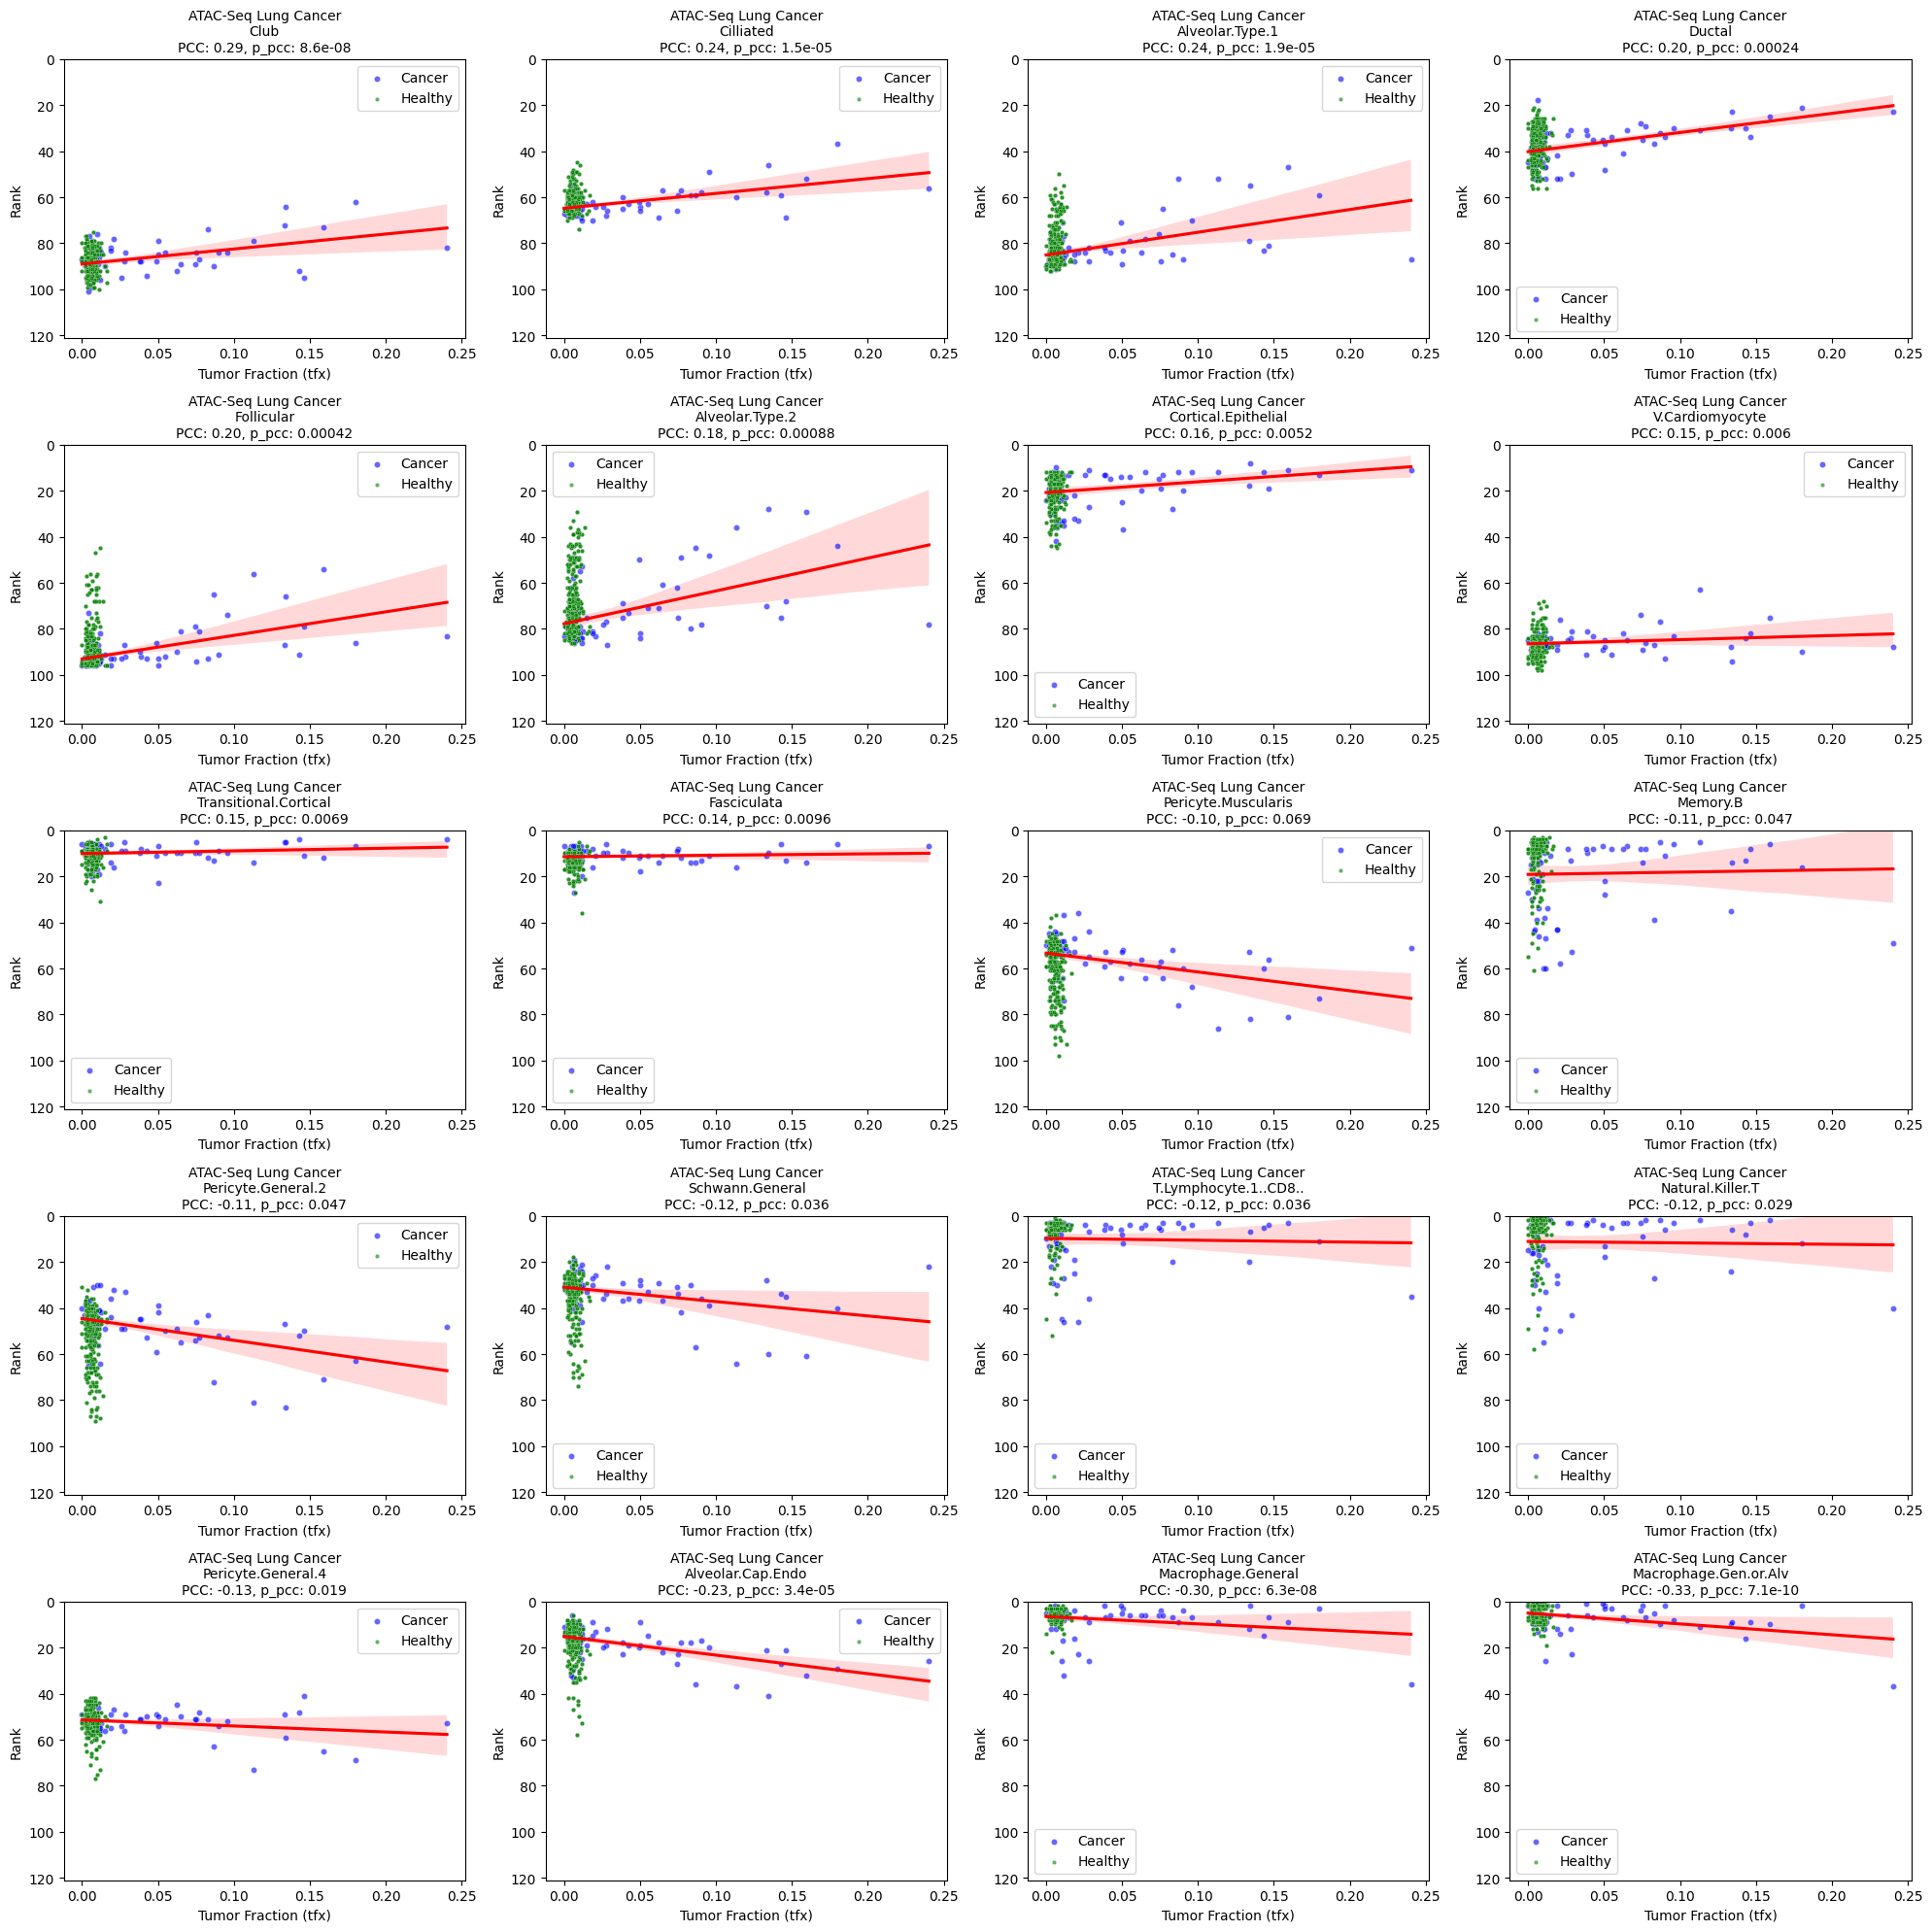

Breast Cancer


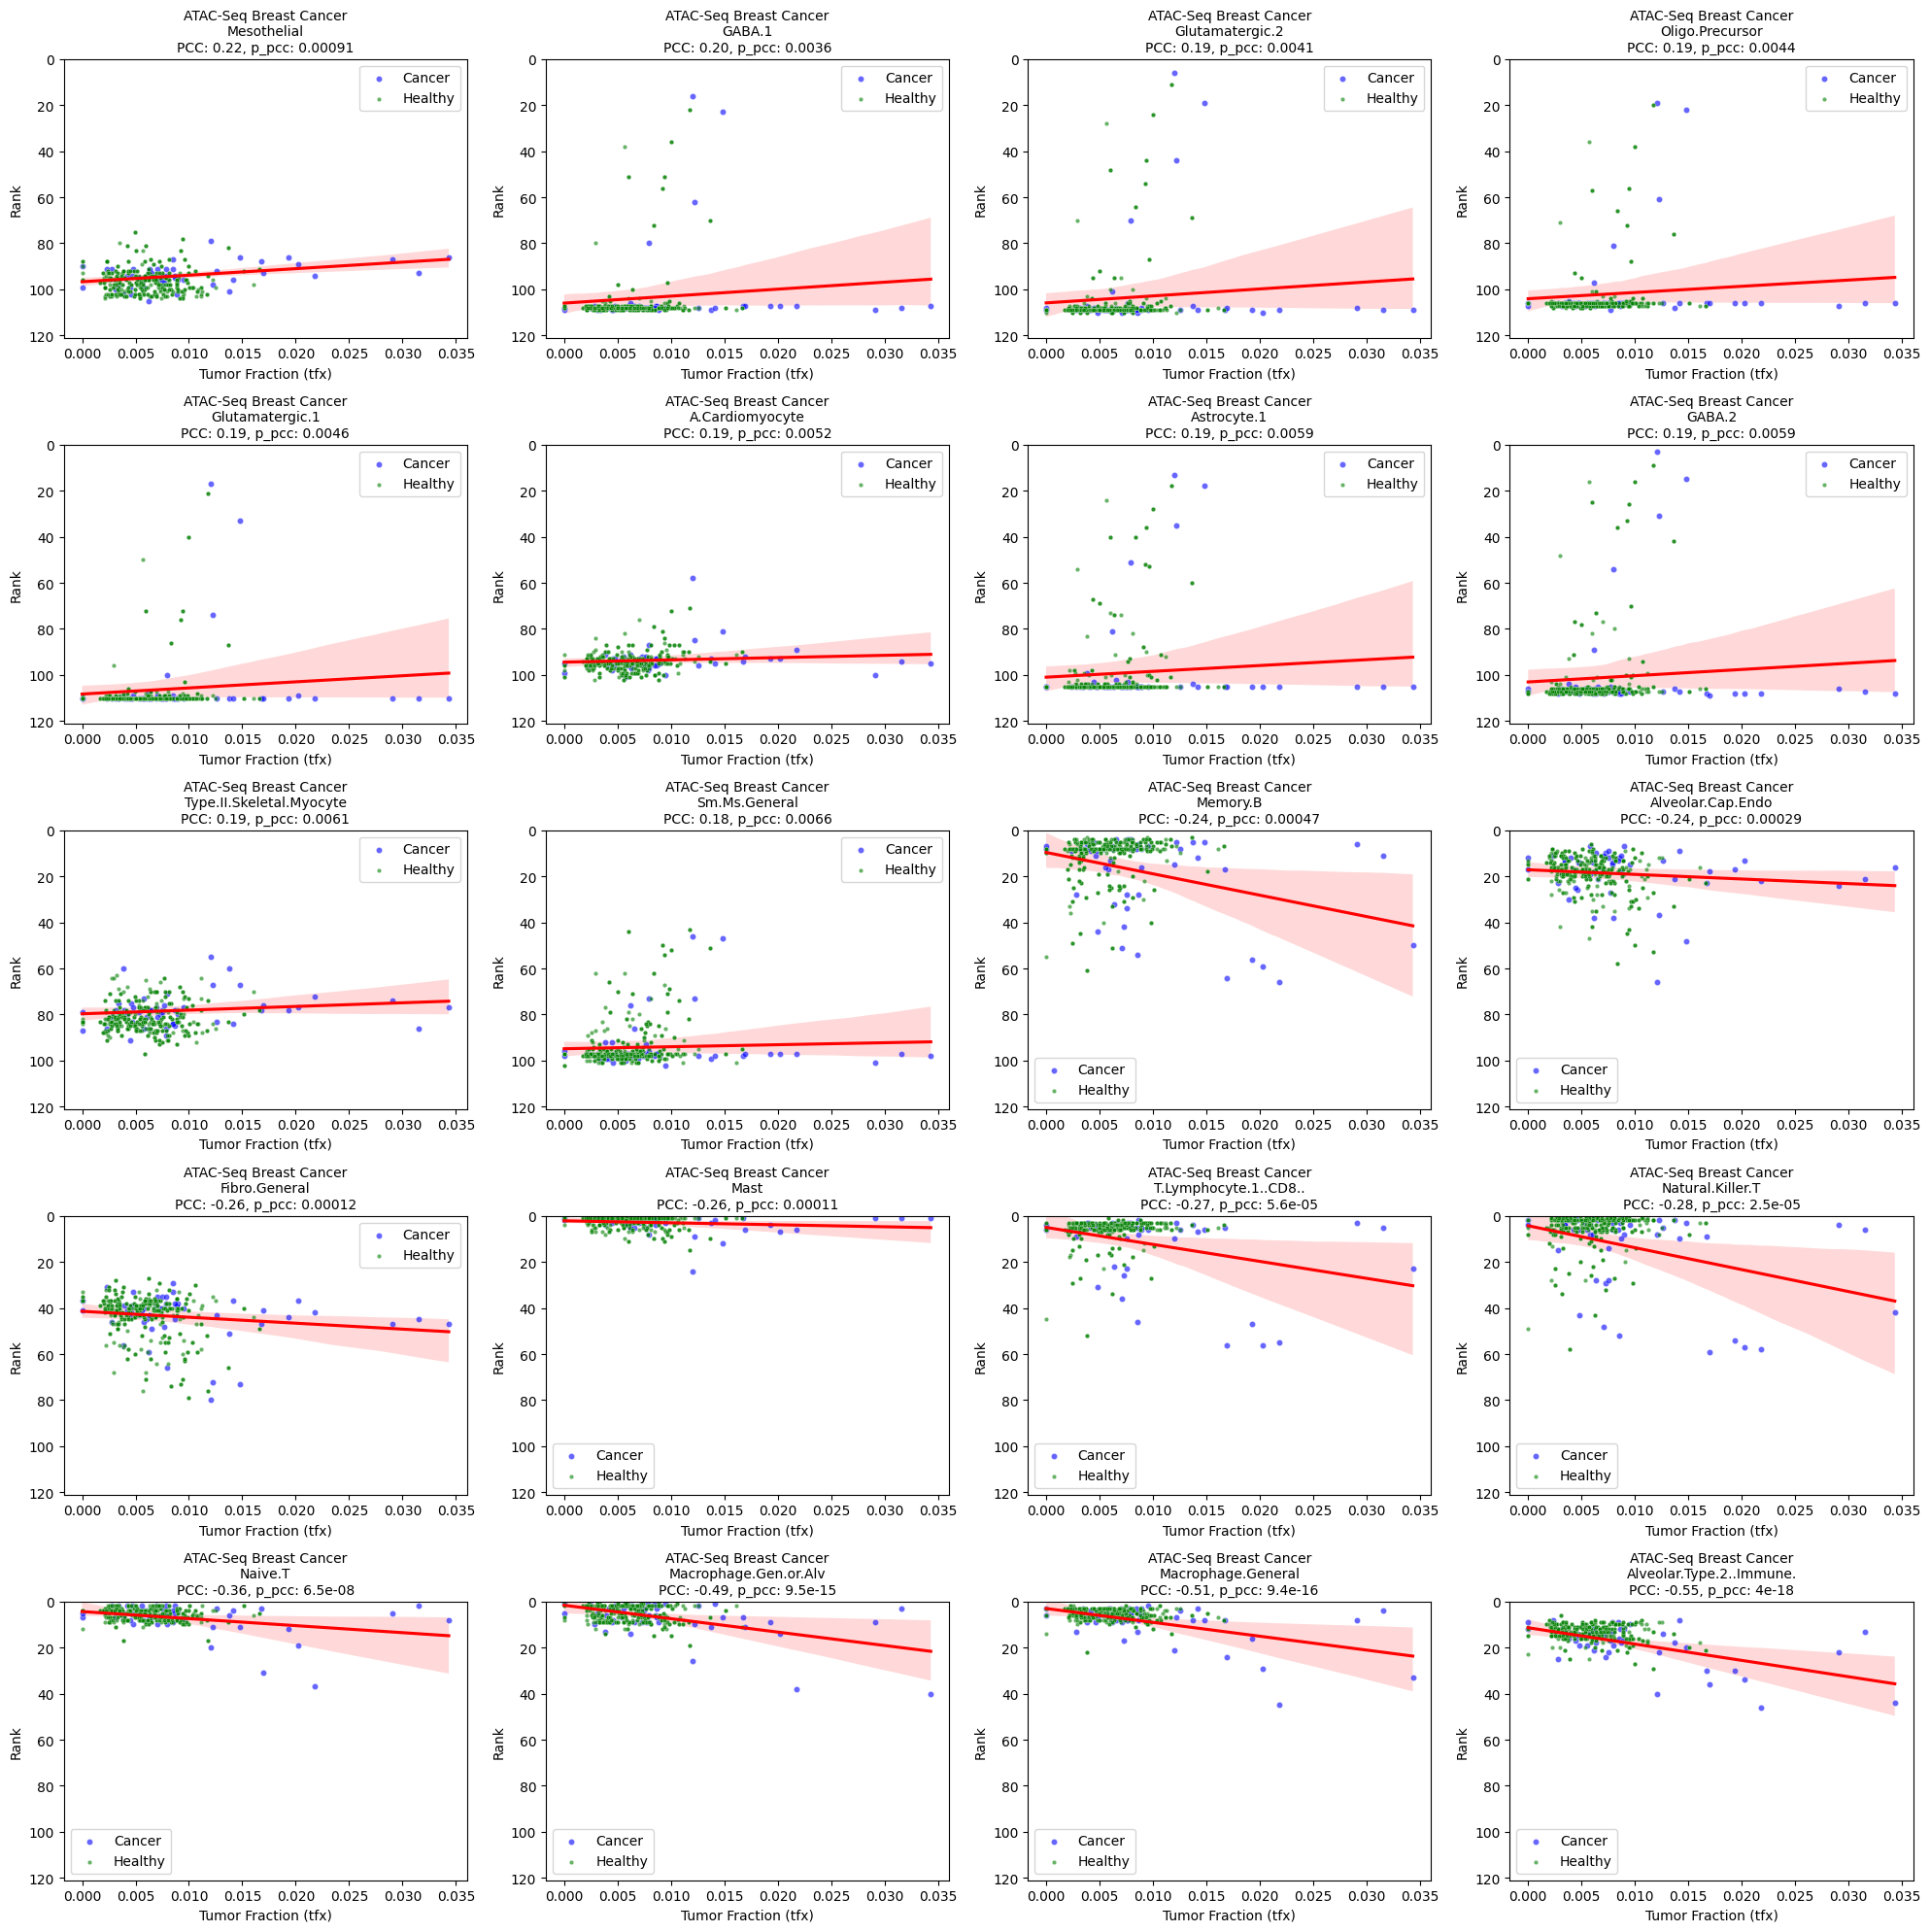

Pancreatic Cancer


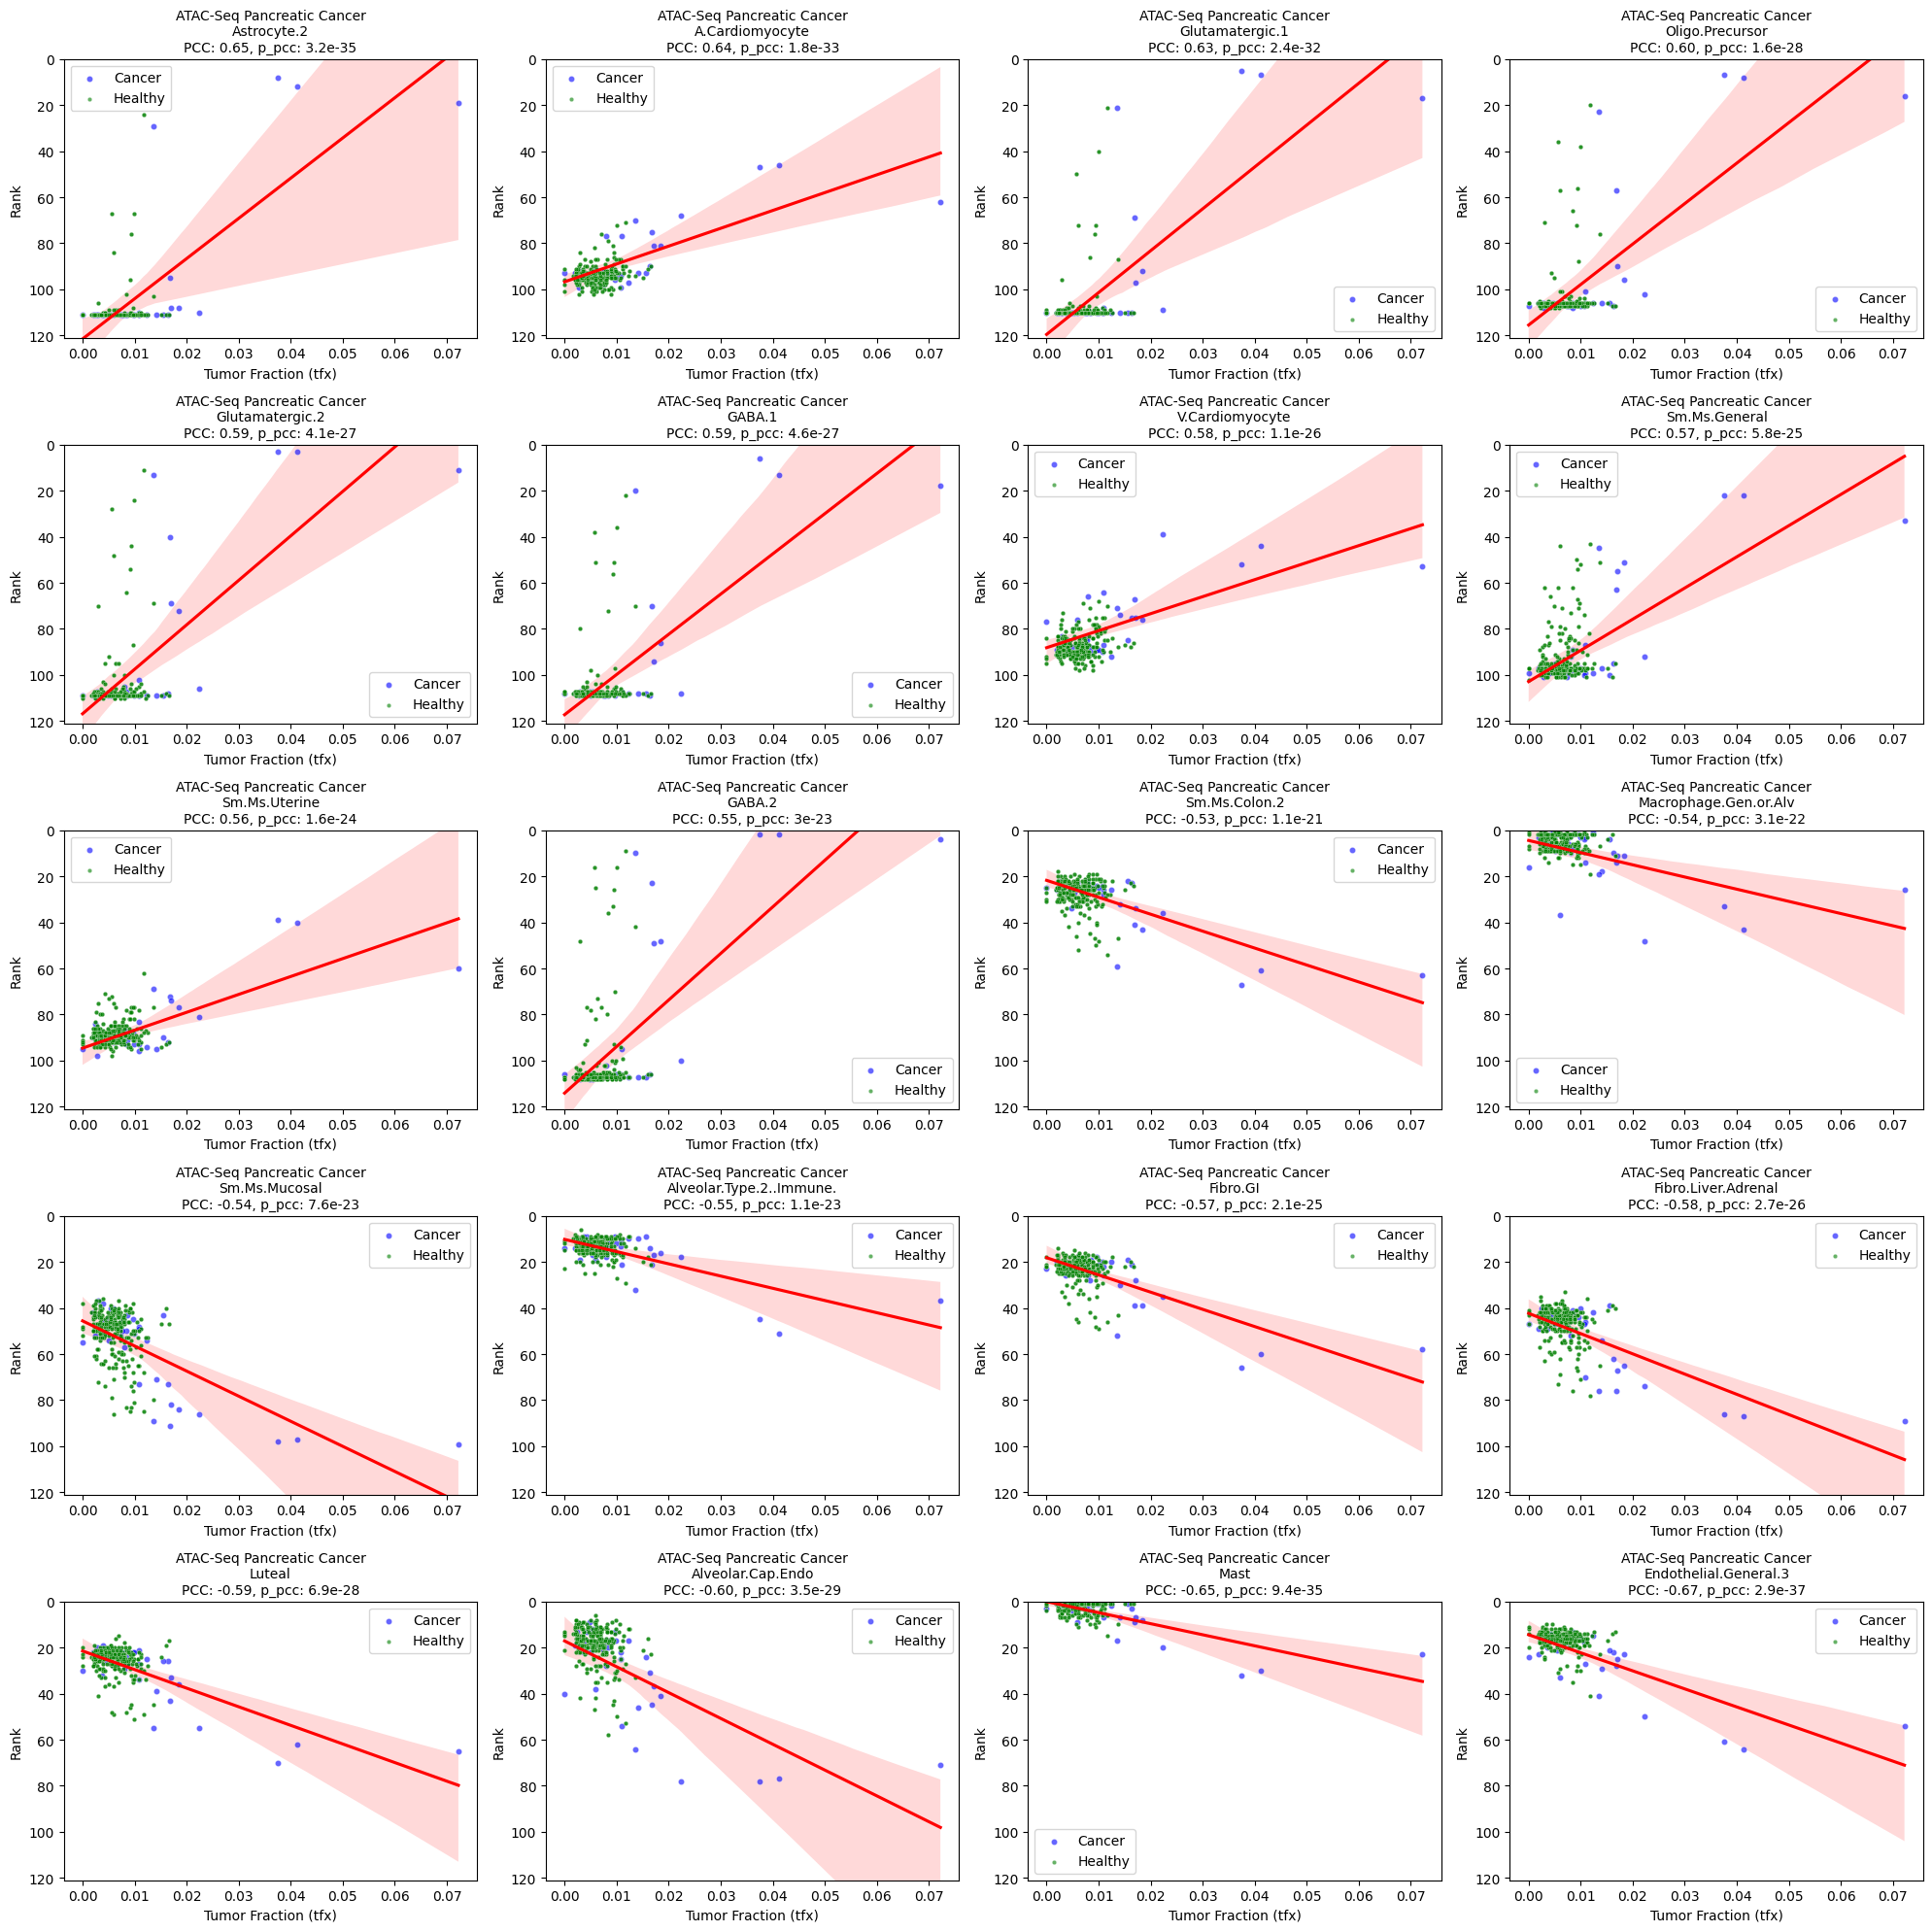

Ovarian Cancer


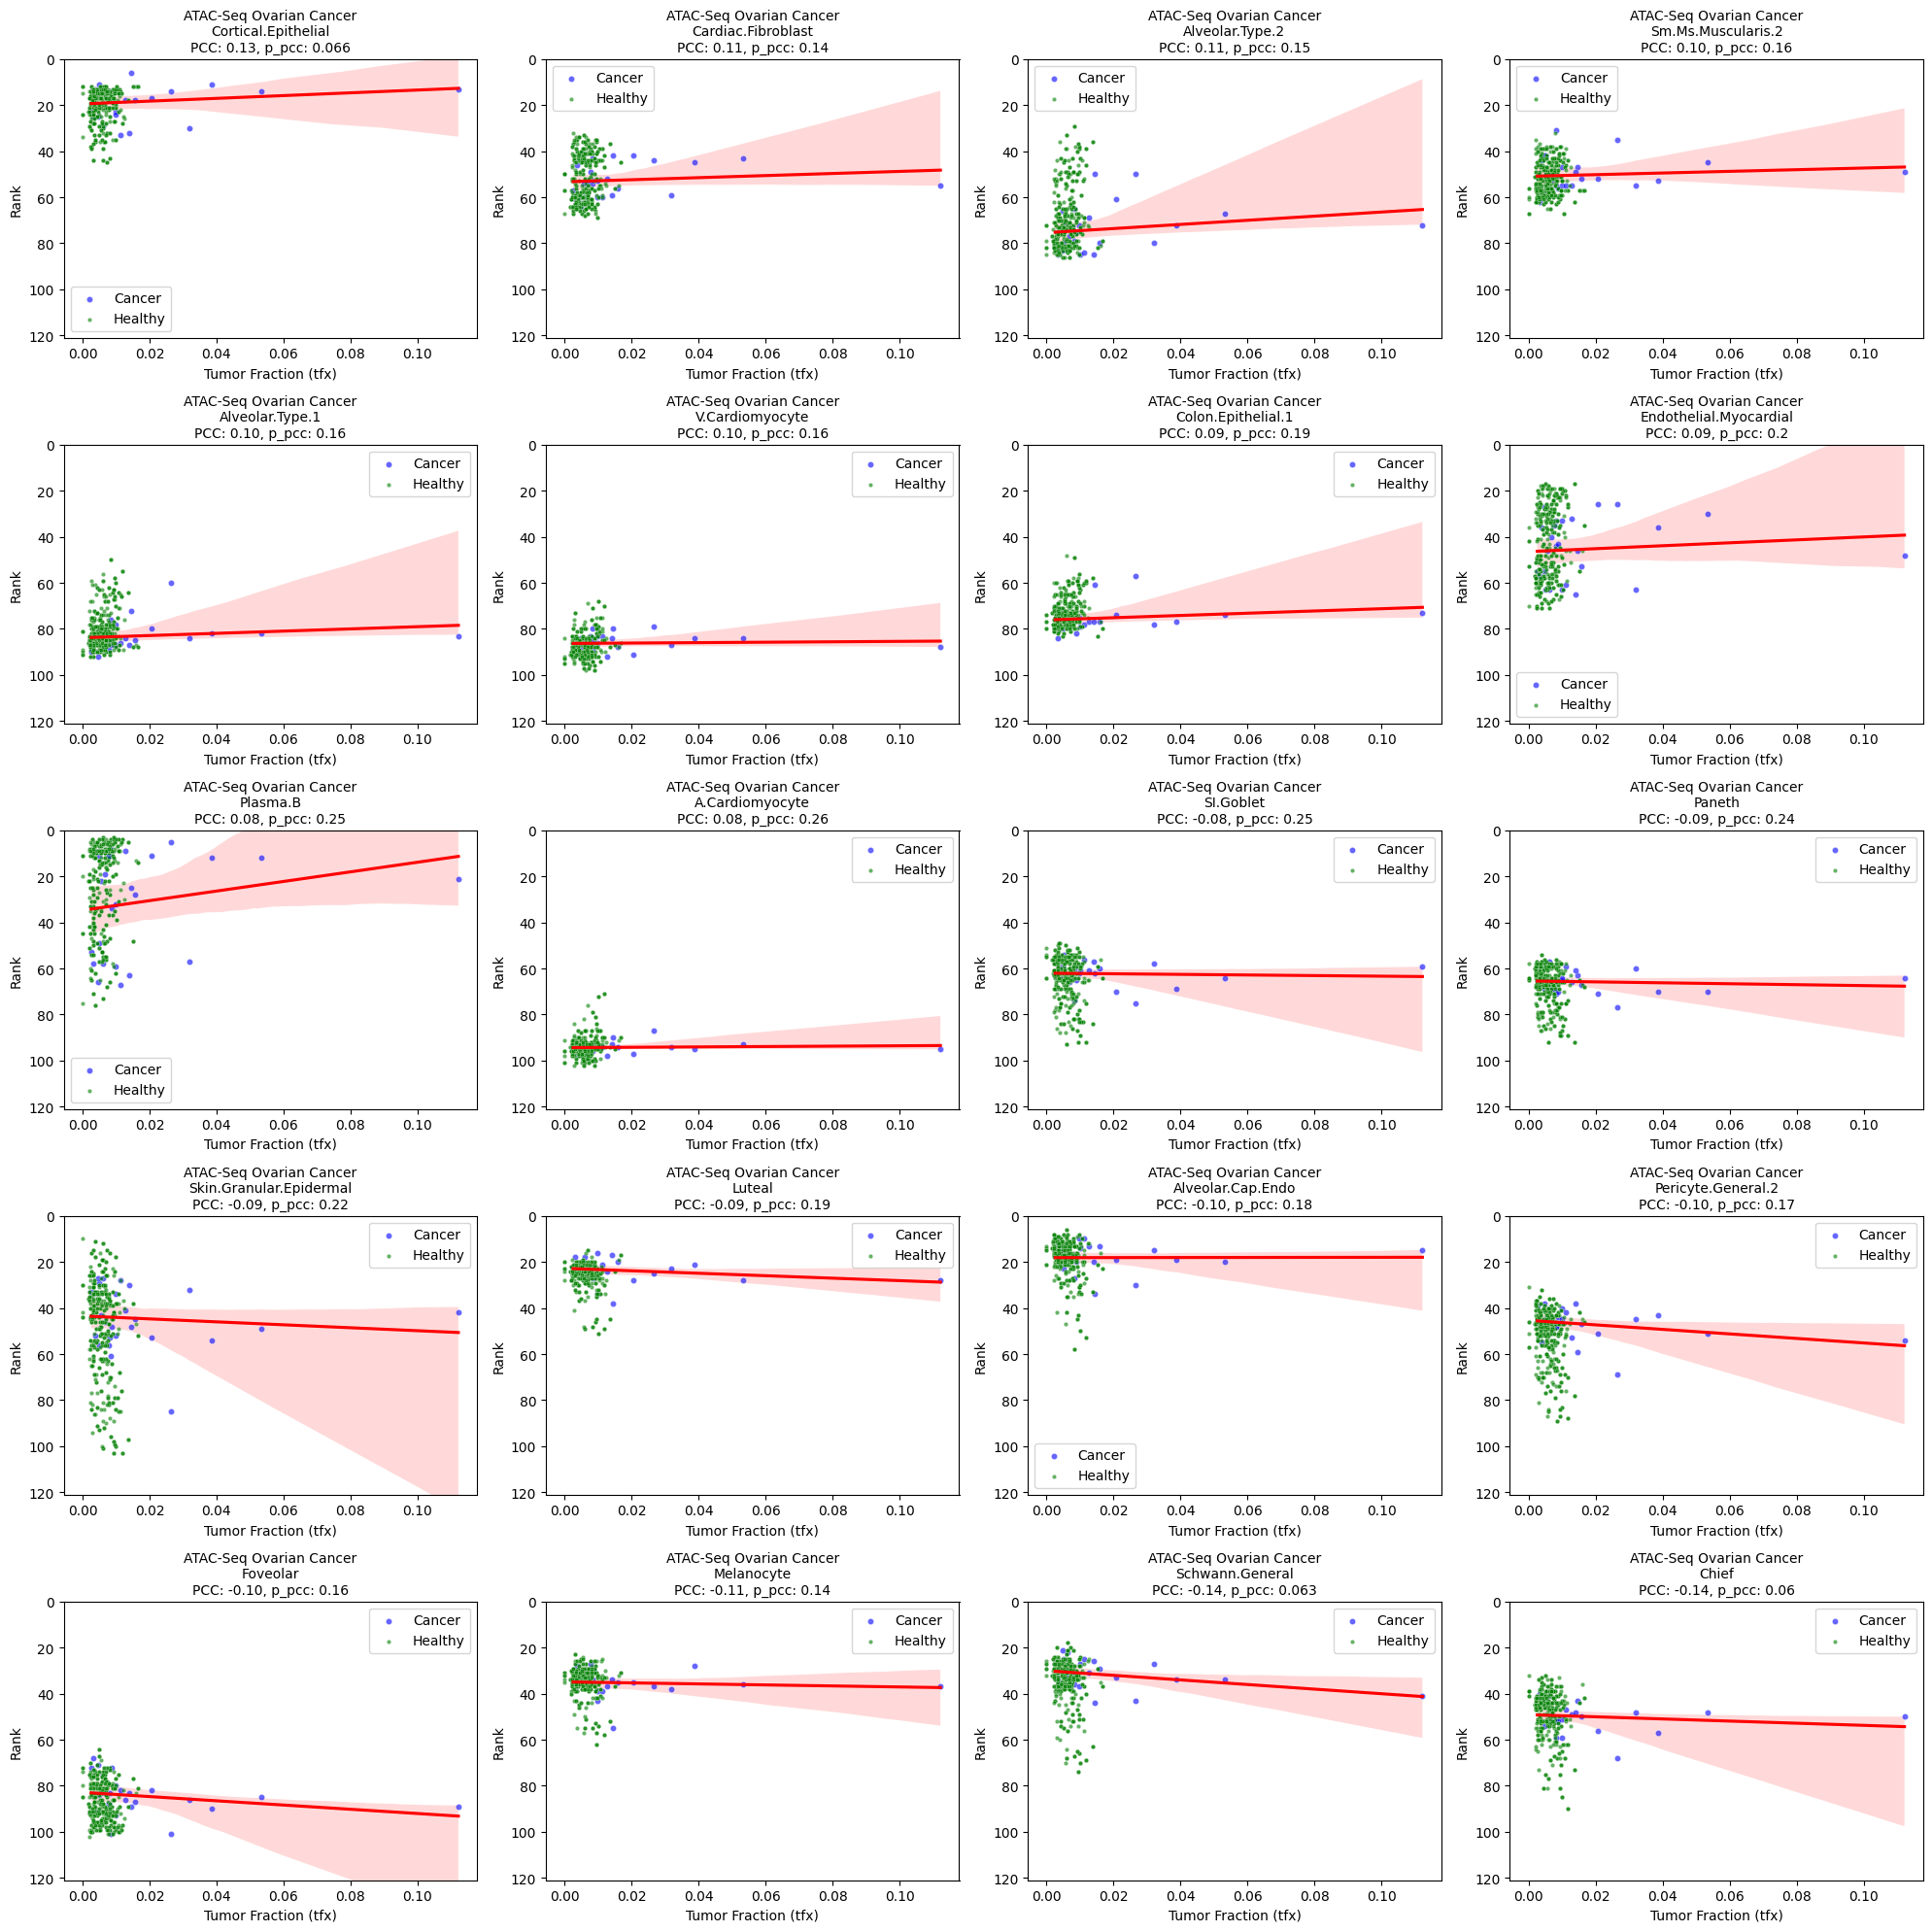

Bile Duct Cancer


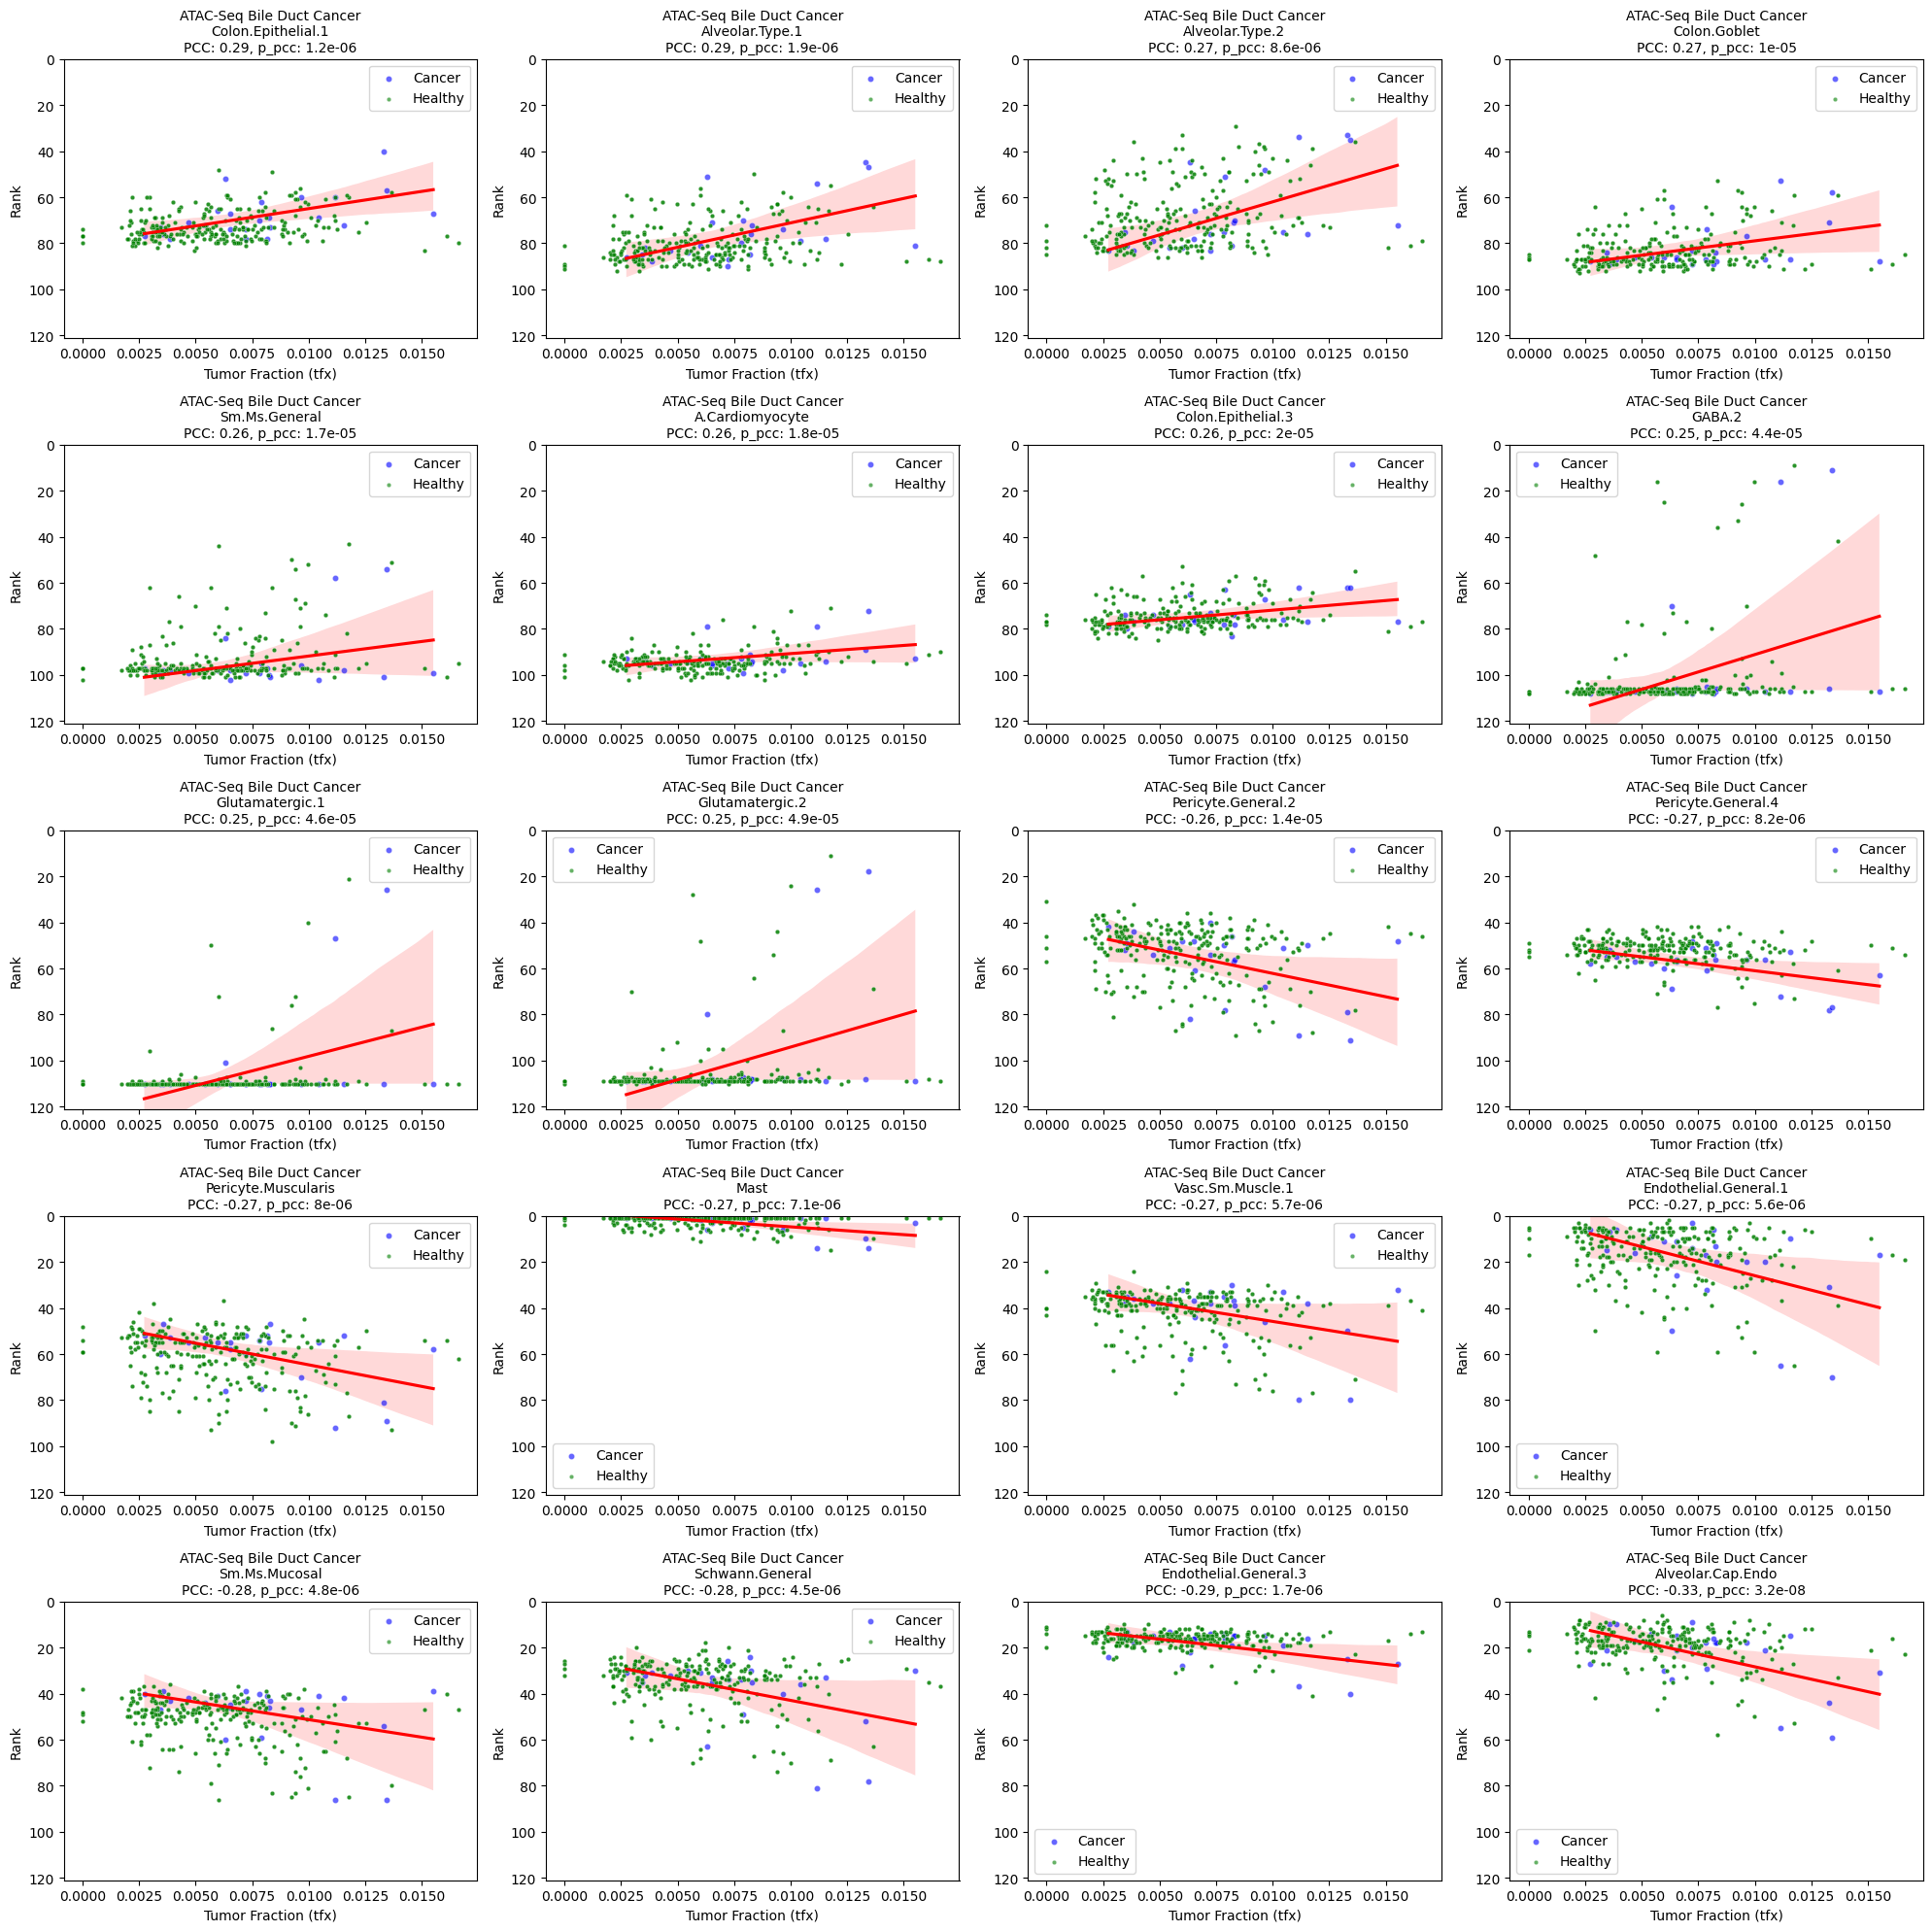

Colorectal Cancer


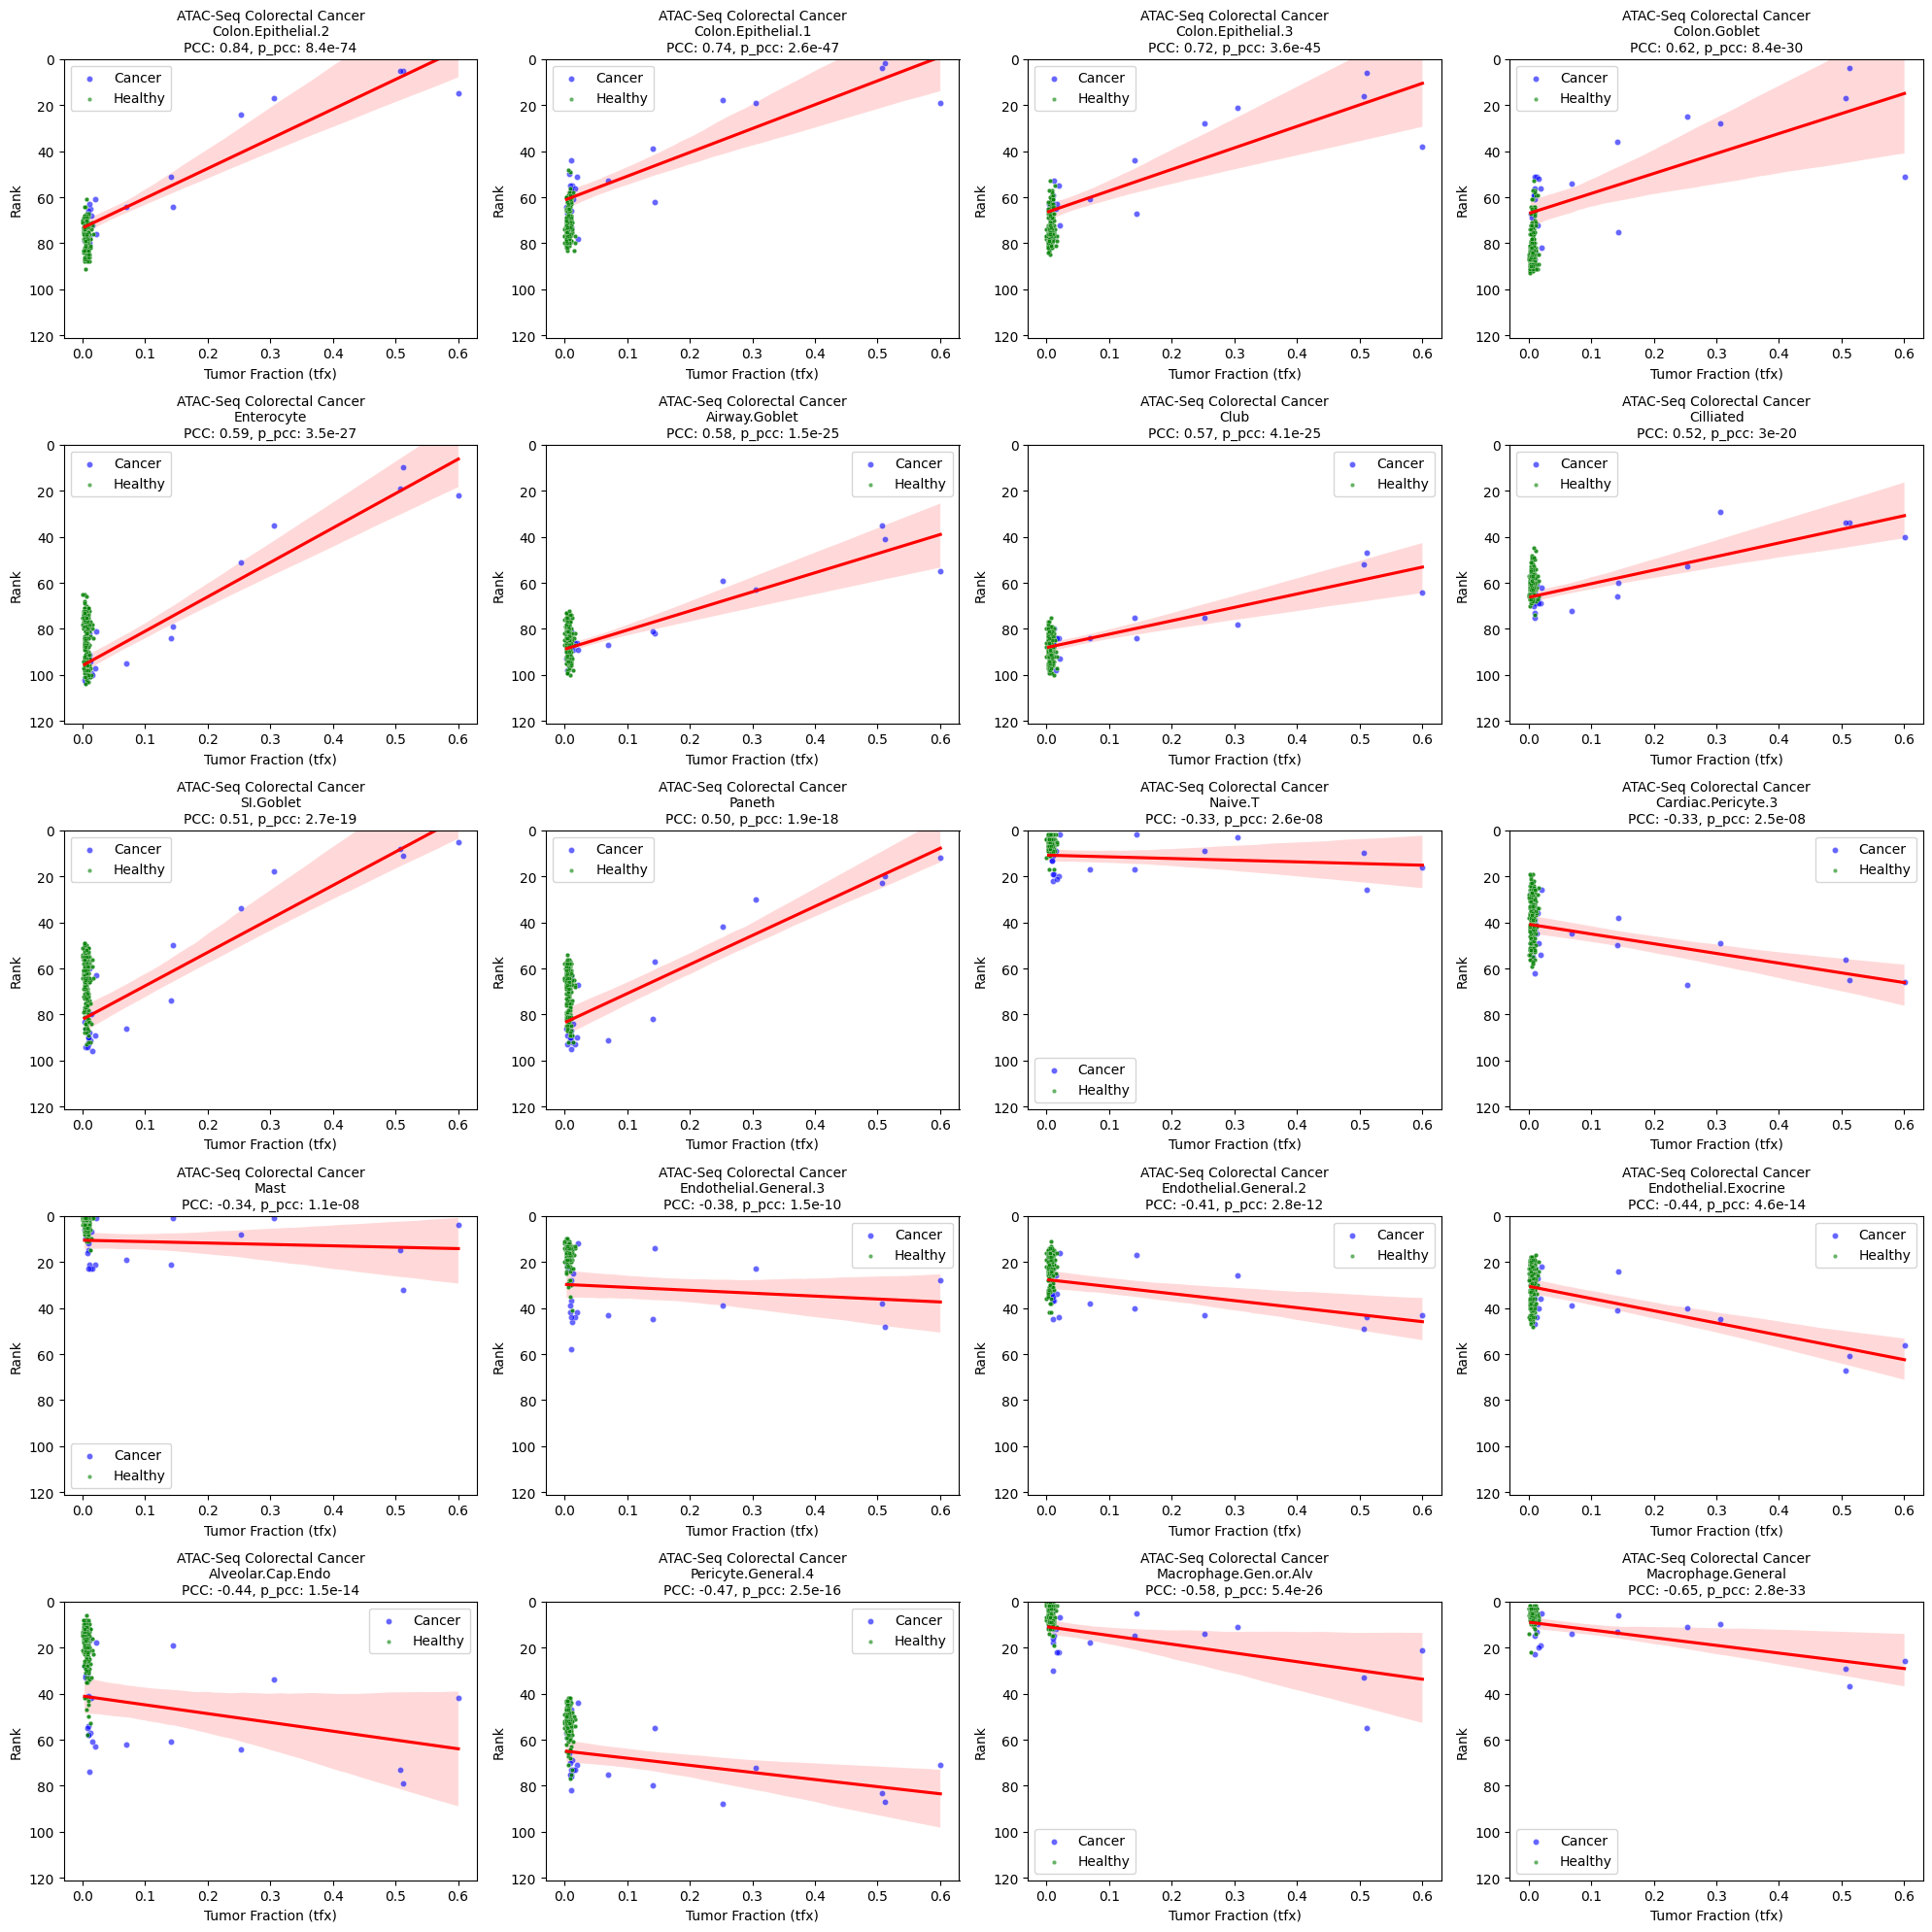

Gastric cancer


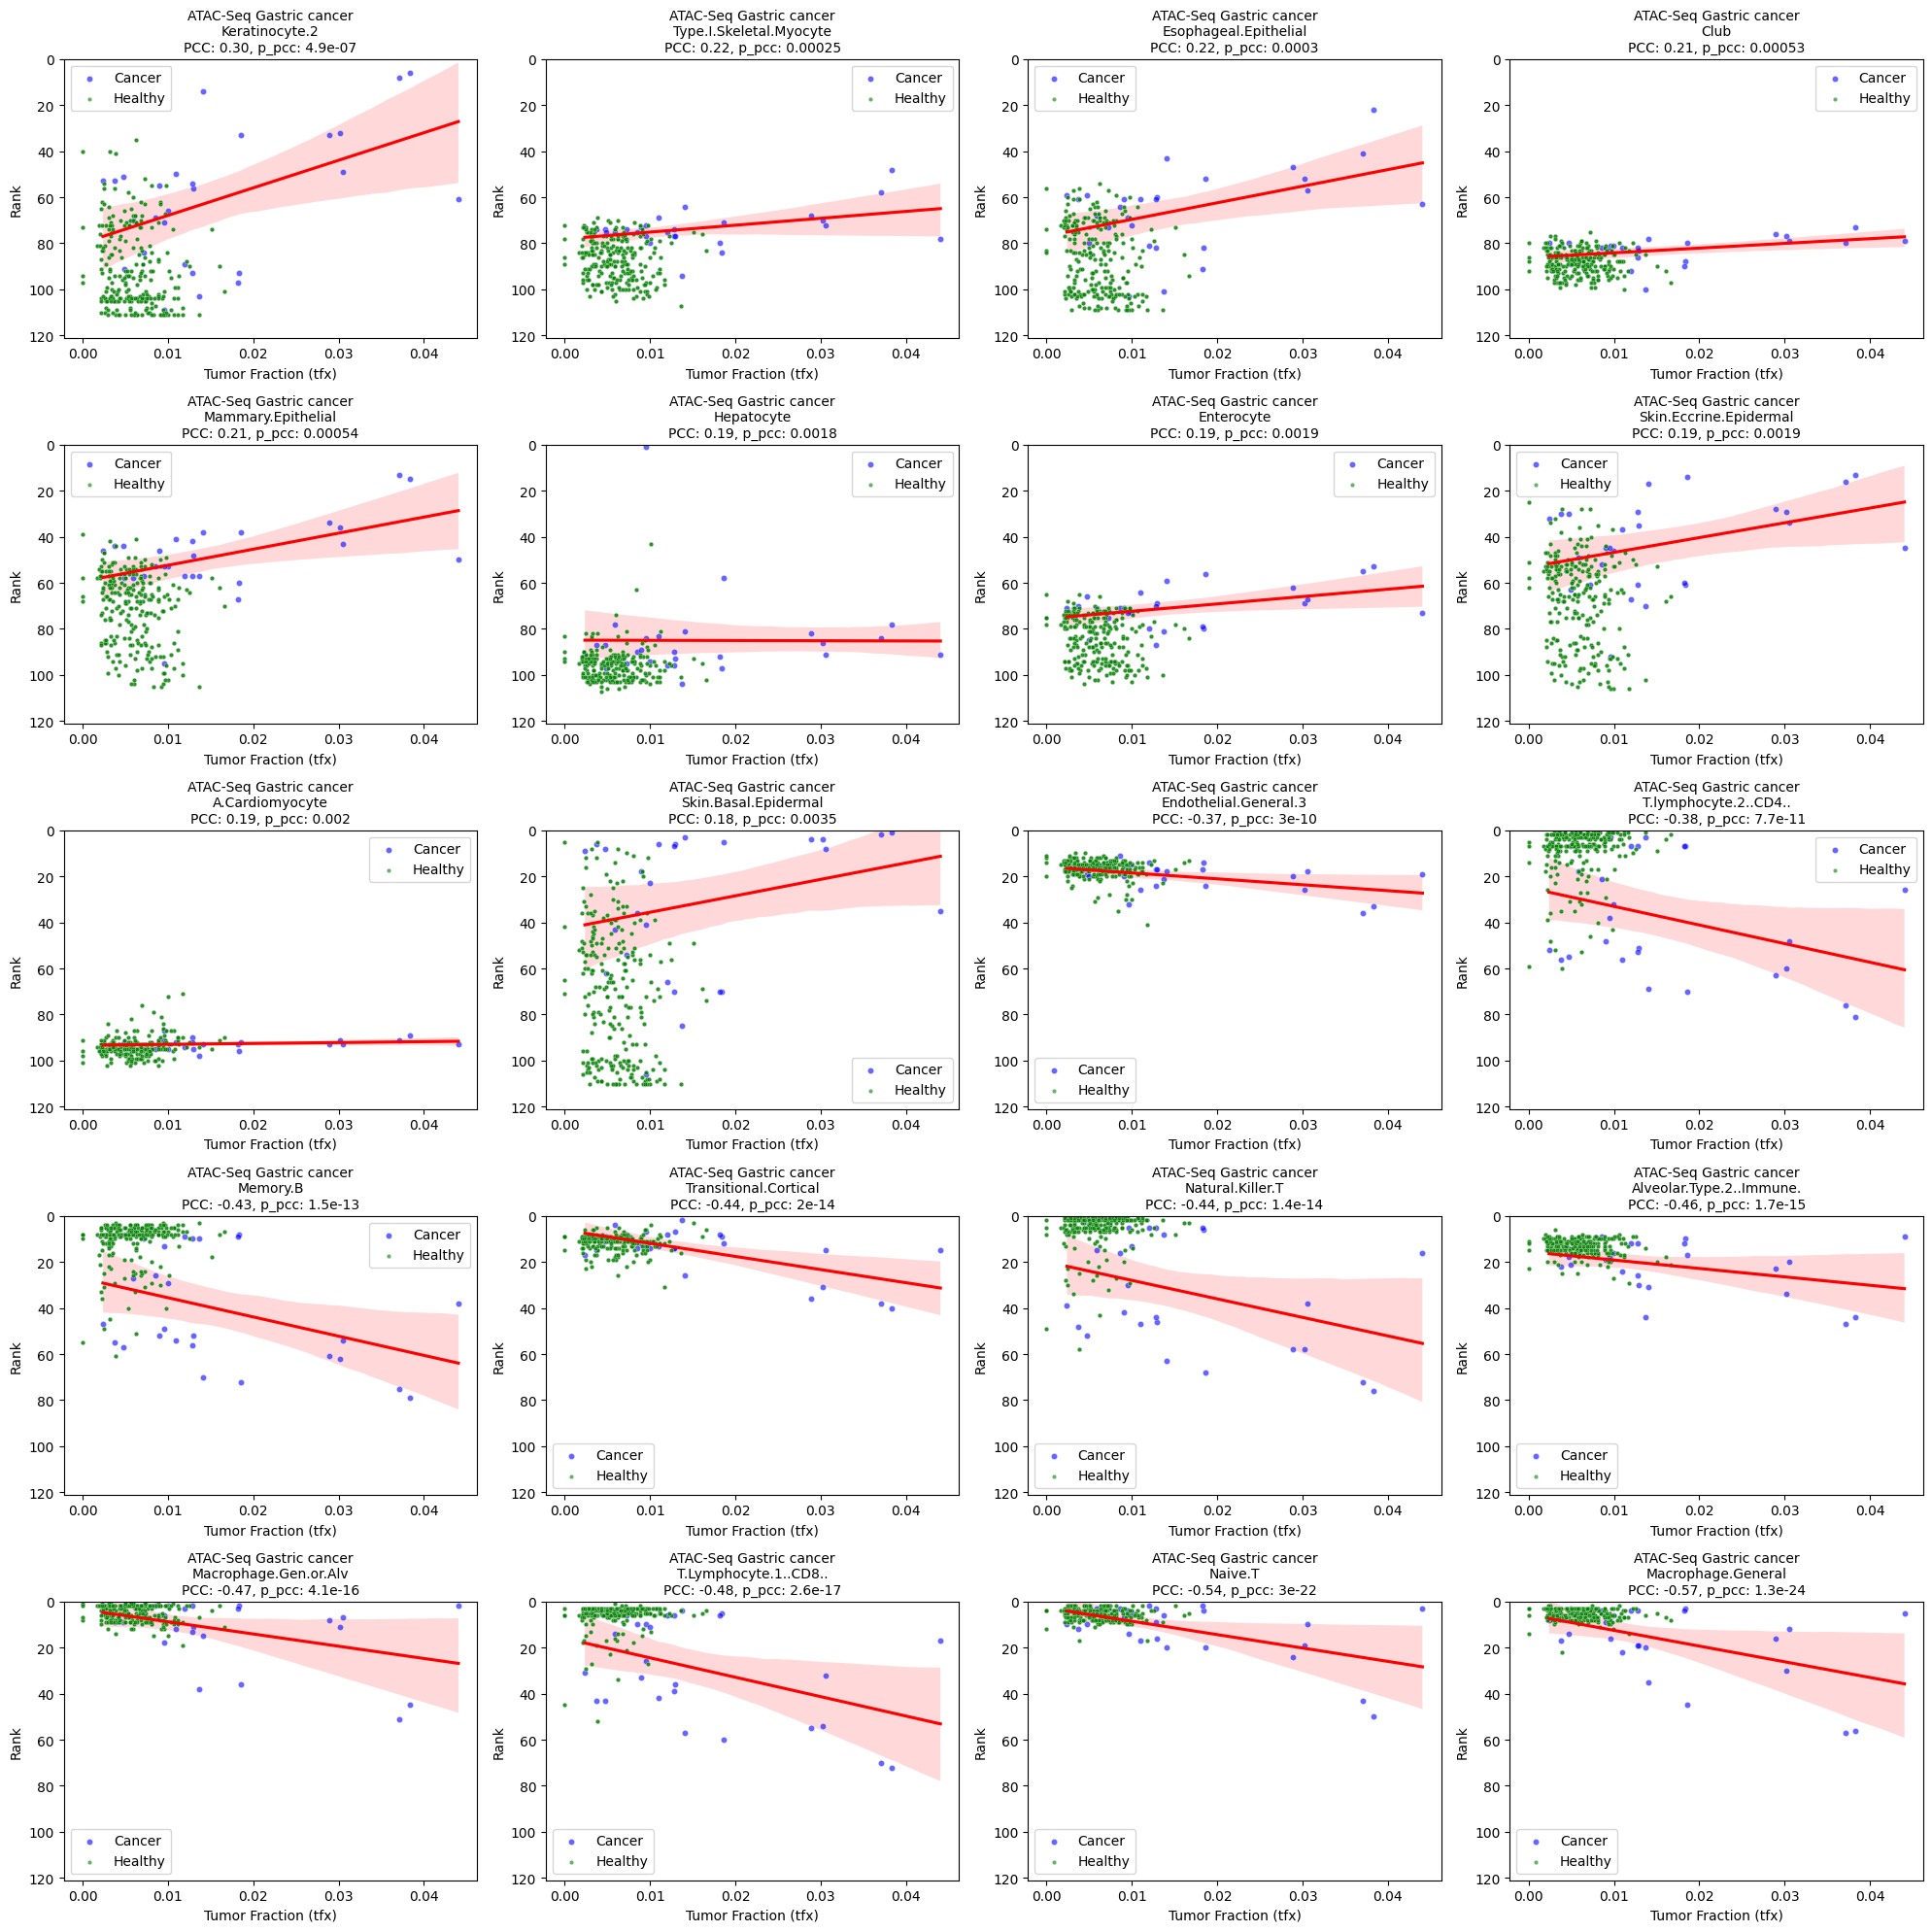

In [37]:
print(refdata_type)

if refdata_type == "RNA":
    refdata_type_label = "RNA"
else:
    refdata_type_label = "ATAC-Seq"

for cancer_type in dic.keys():
    print(cancer_type)
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))

    # Flatten axs array for easy iteration
    axs = axs.flatten()
    plot_count = 0
    for cell_type in plot_dic[cancer_type].keys():
        p_value_pcc = plot_dic[cancer_type][cell_type]['p_value']
        PCC = plot_dic[cancer_type][cell_type]['PCC']
        df = plot_dic[cancer_type][cell_type]['df']

        # add healthy ranks if wanted
        healthy = data[(data['status'] == 'Healthy') & (data['cell_type'] == cell_type)]
        merged = pd.concat([df, healthy], ignore_index=True)

        # Set up the color palette for the two groups
        palette = {'Cancer': 'blue', 'Healthy': 'green'}

        # Plotting on the current subplot axis, where 'group' is the column representing your two groups
        # Regression plot, invisible points alpa = 0.0
        sns.regplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                    scatter_kws={'color': palette['Cancer'], 's': 20, 'alpha': 0.0},
                    line_kws={'color': 'red'}, ax=axs[plot_count])

        # Plotting for Cancer group - dummy - 
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                        color=palette['Cancer'], s=20, alpha=0.6, label='Cancer', ax=axs[plot_count])
        
        # Plotting for Healthy group
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == 'Healthy'],
                        color=palette['Healthy'], s=10, alpha=0.6, label='Healthy', ax=axs[plot_count])

        nr_cell_types = len(data['cell_type'].unique())
        # Set the title and labels for each subplot
        axs[plot_count].set_title(f'{refdata_type_label} {cancer_type}\n{cell_type}\nPCC: {PCC:.2f}, p_pcc: {p_value_pcc:.2g}', fontsize=10)
        axs[plot_count].set_xlabel('Tumor Fraction (tfx)')
        axs[plot_count].set_ylabel('Rank')
        axs[plot_count].set_ylim(0, nr_cell_types + 10)
        axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
        
        plot_count += 1

    # Adjust display settings
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    plt.tight_layout()

    # Show the final plot
    plt.show()


Lung Cancer


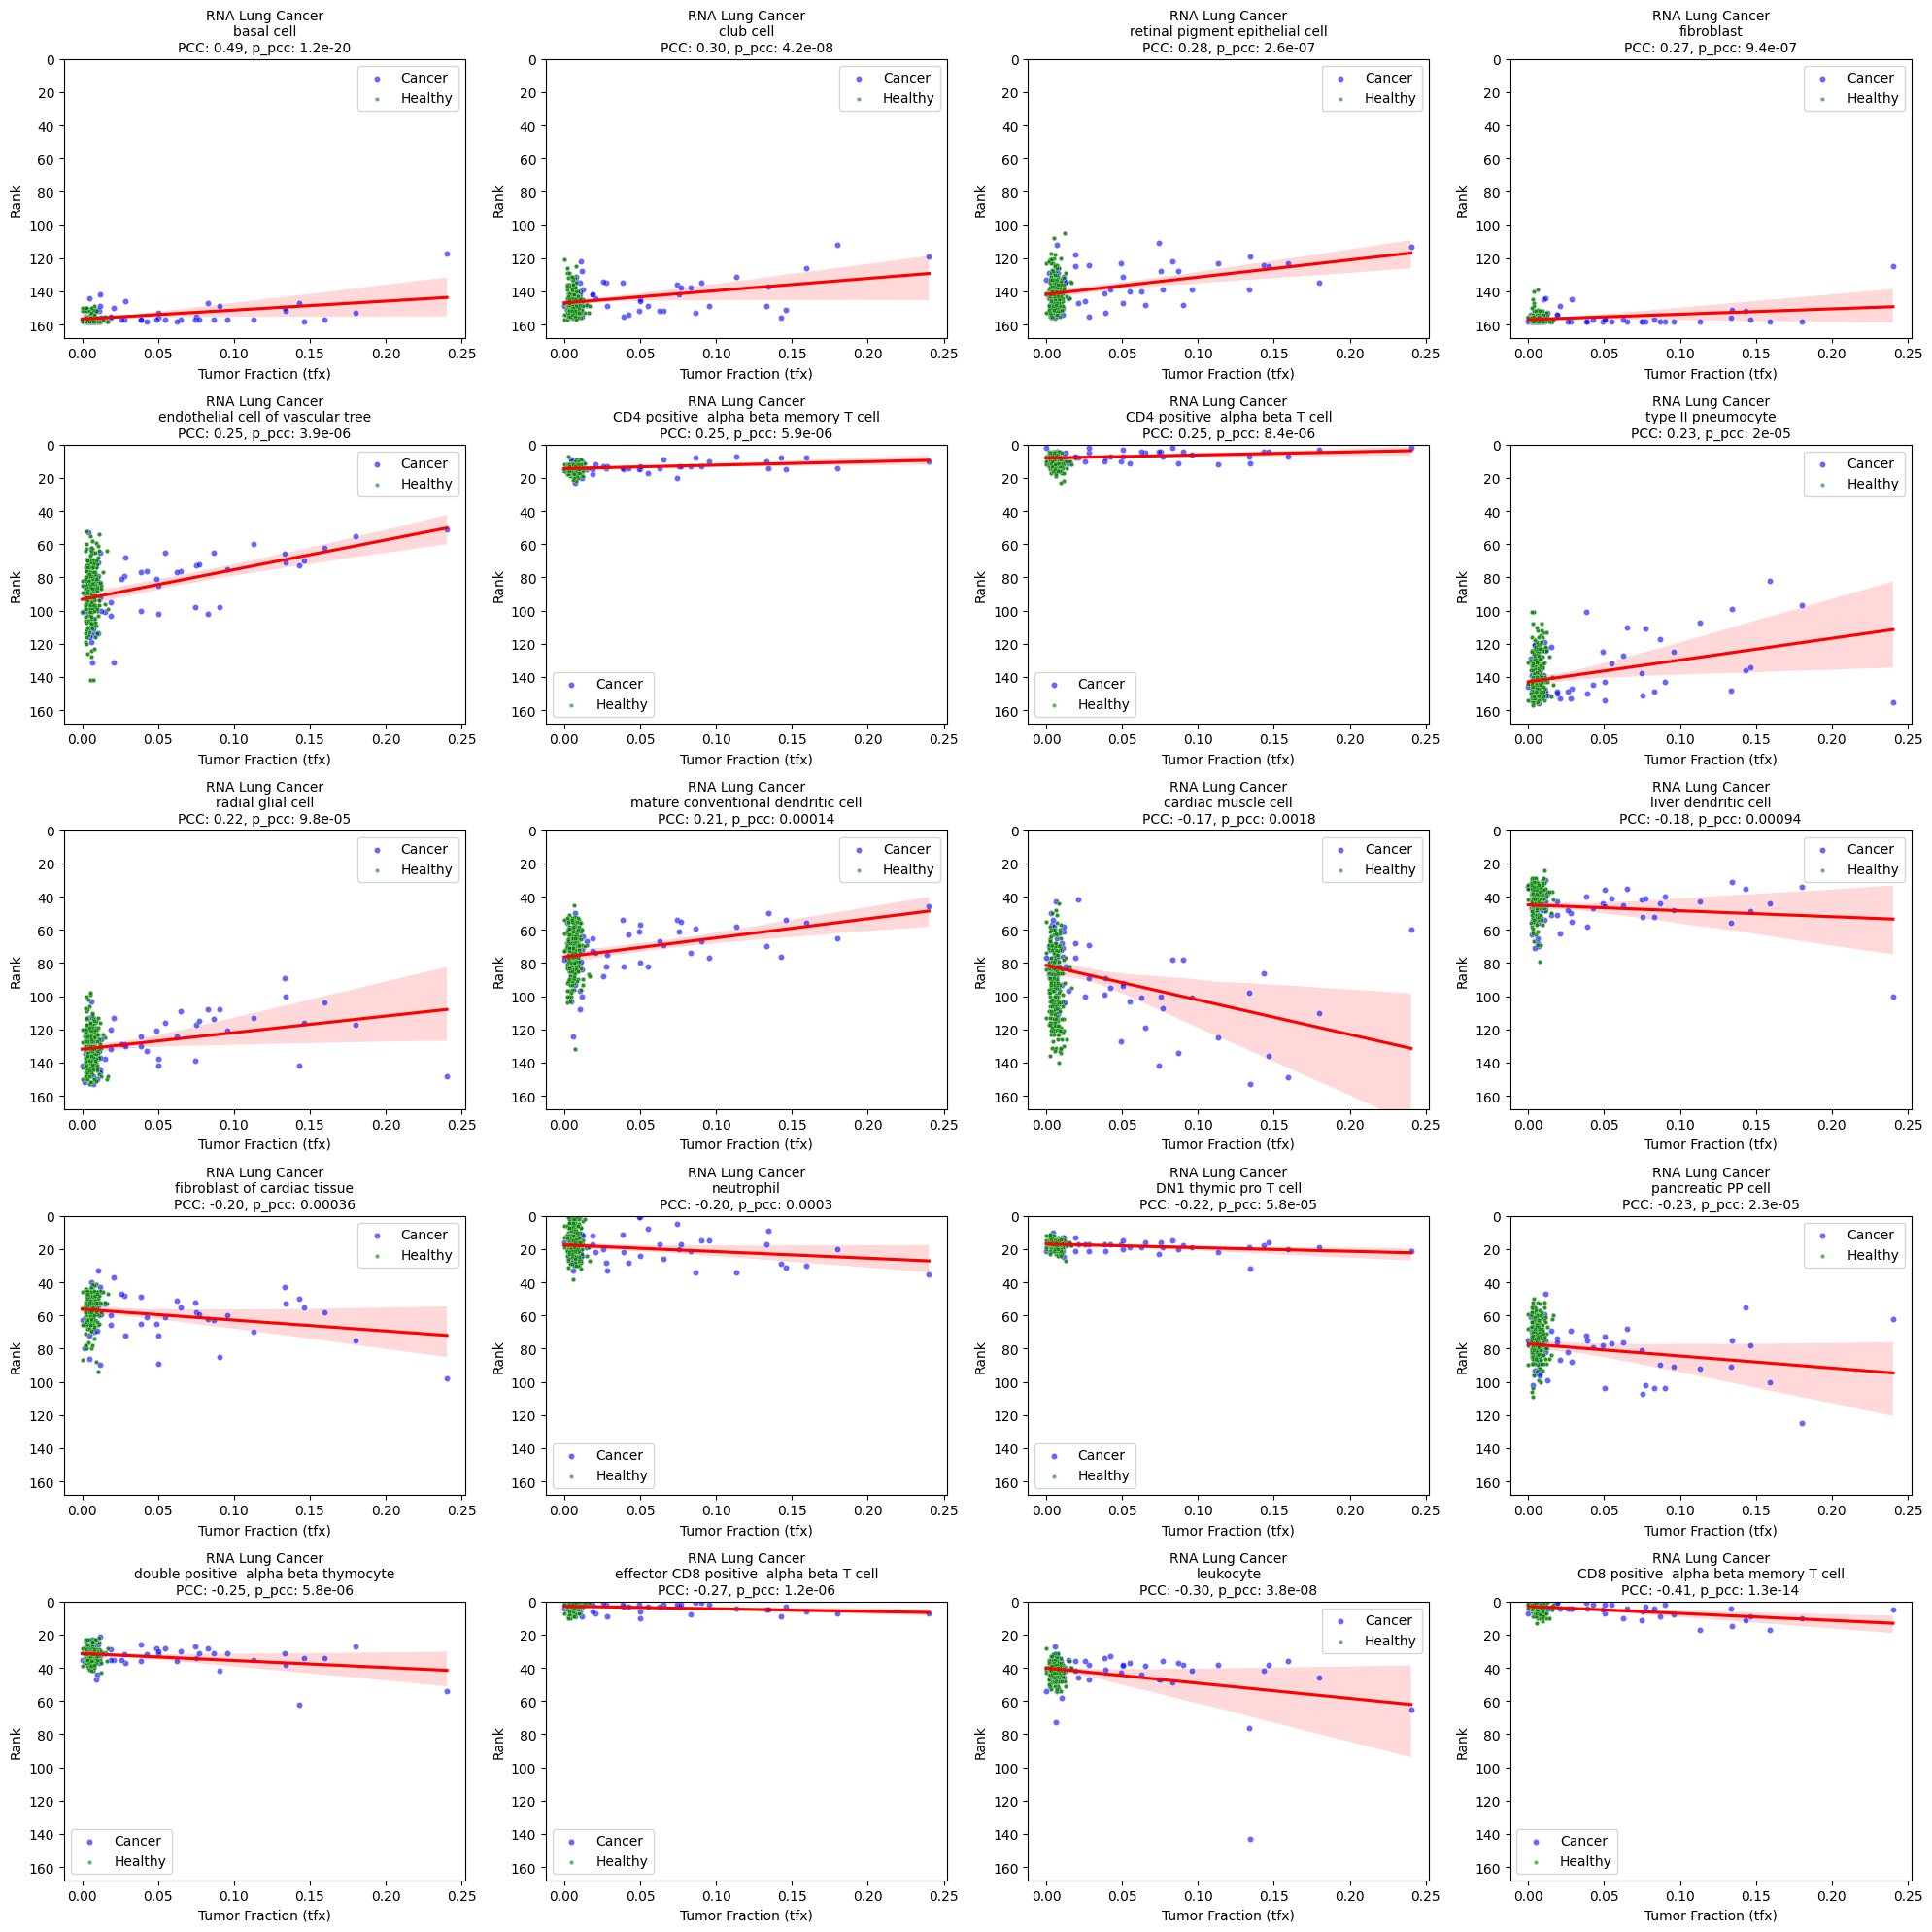

Breast Cancer


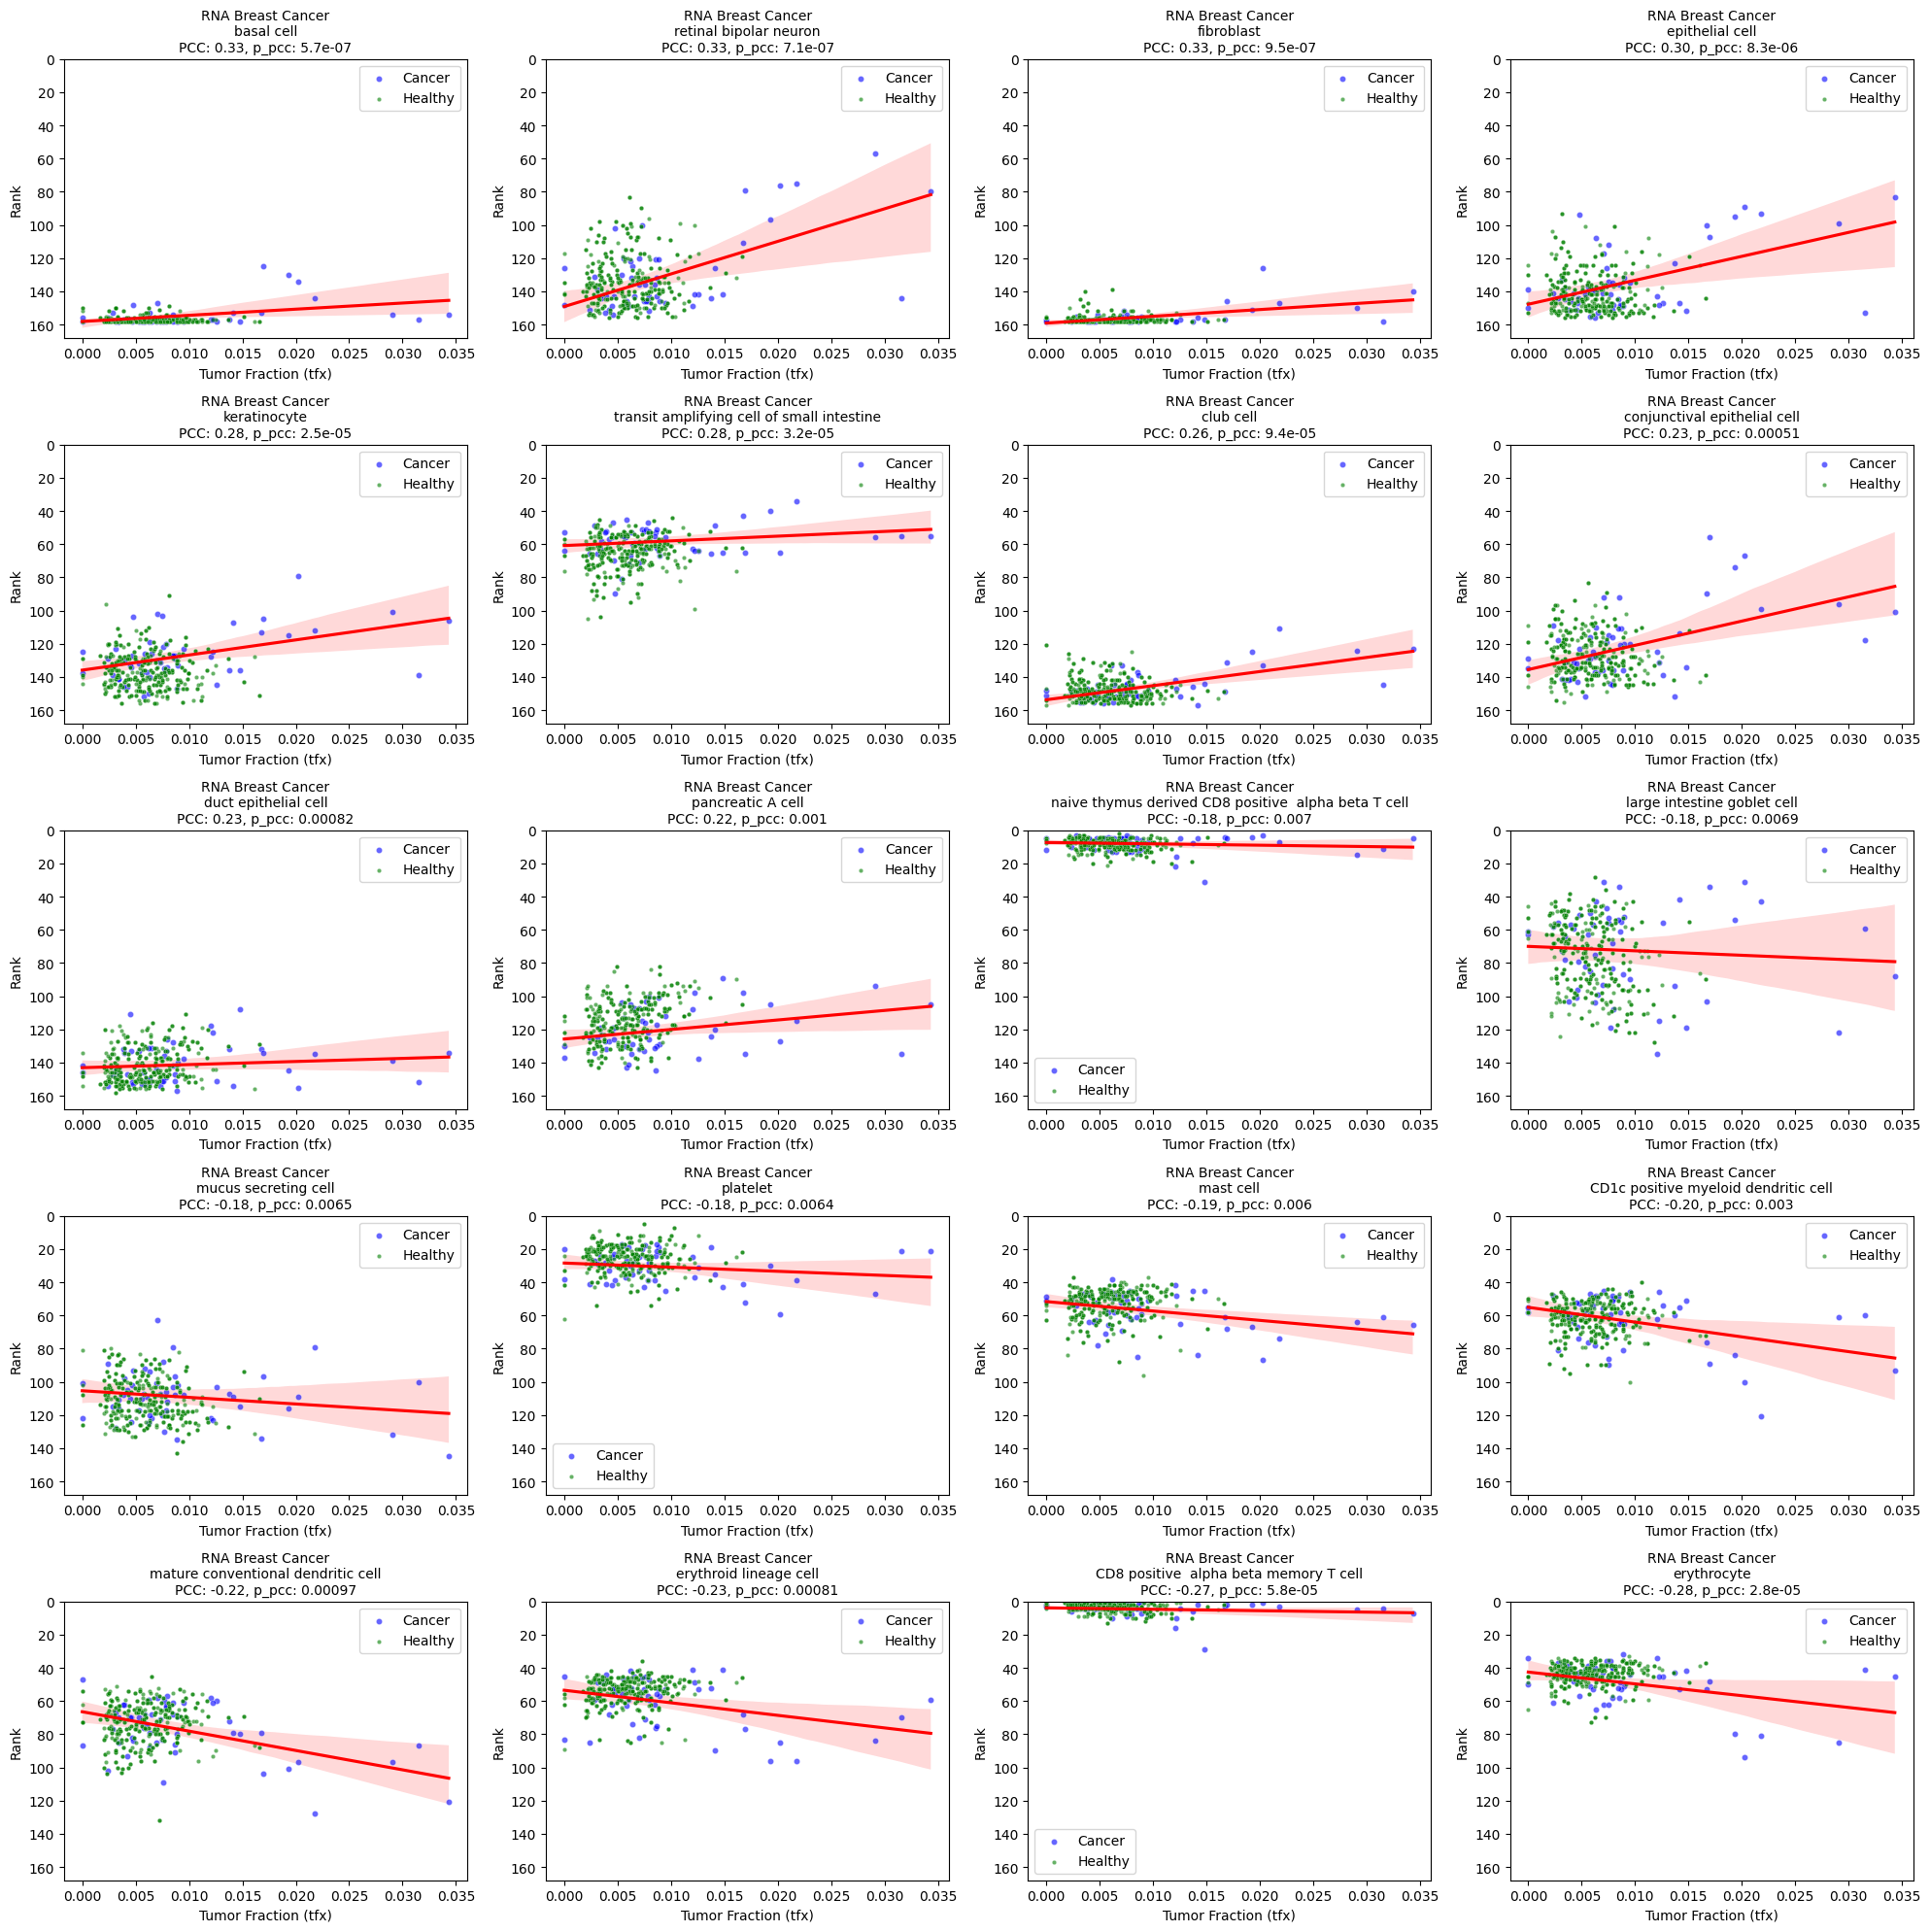

Pancreatic Cancer


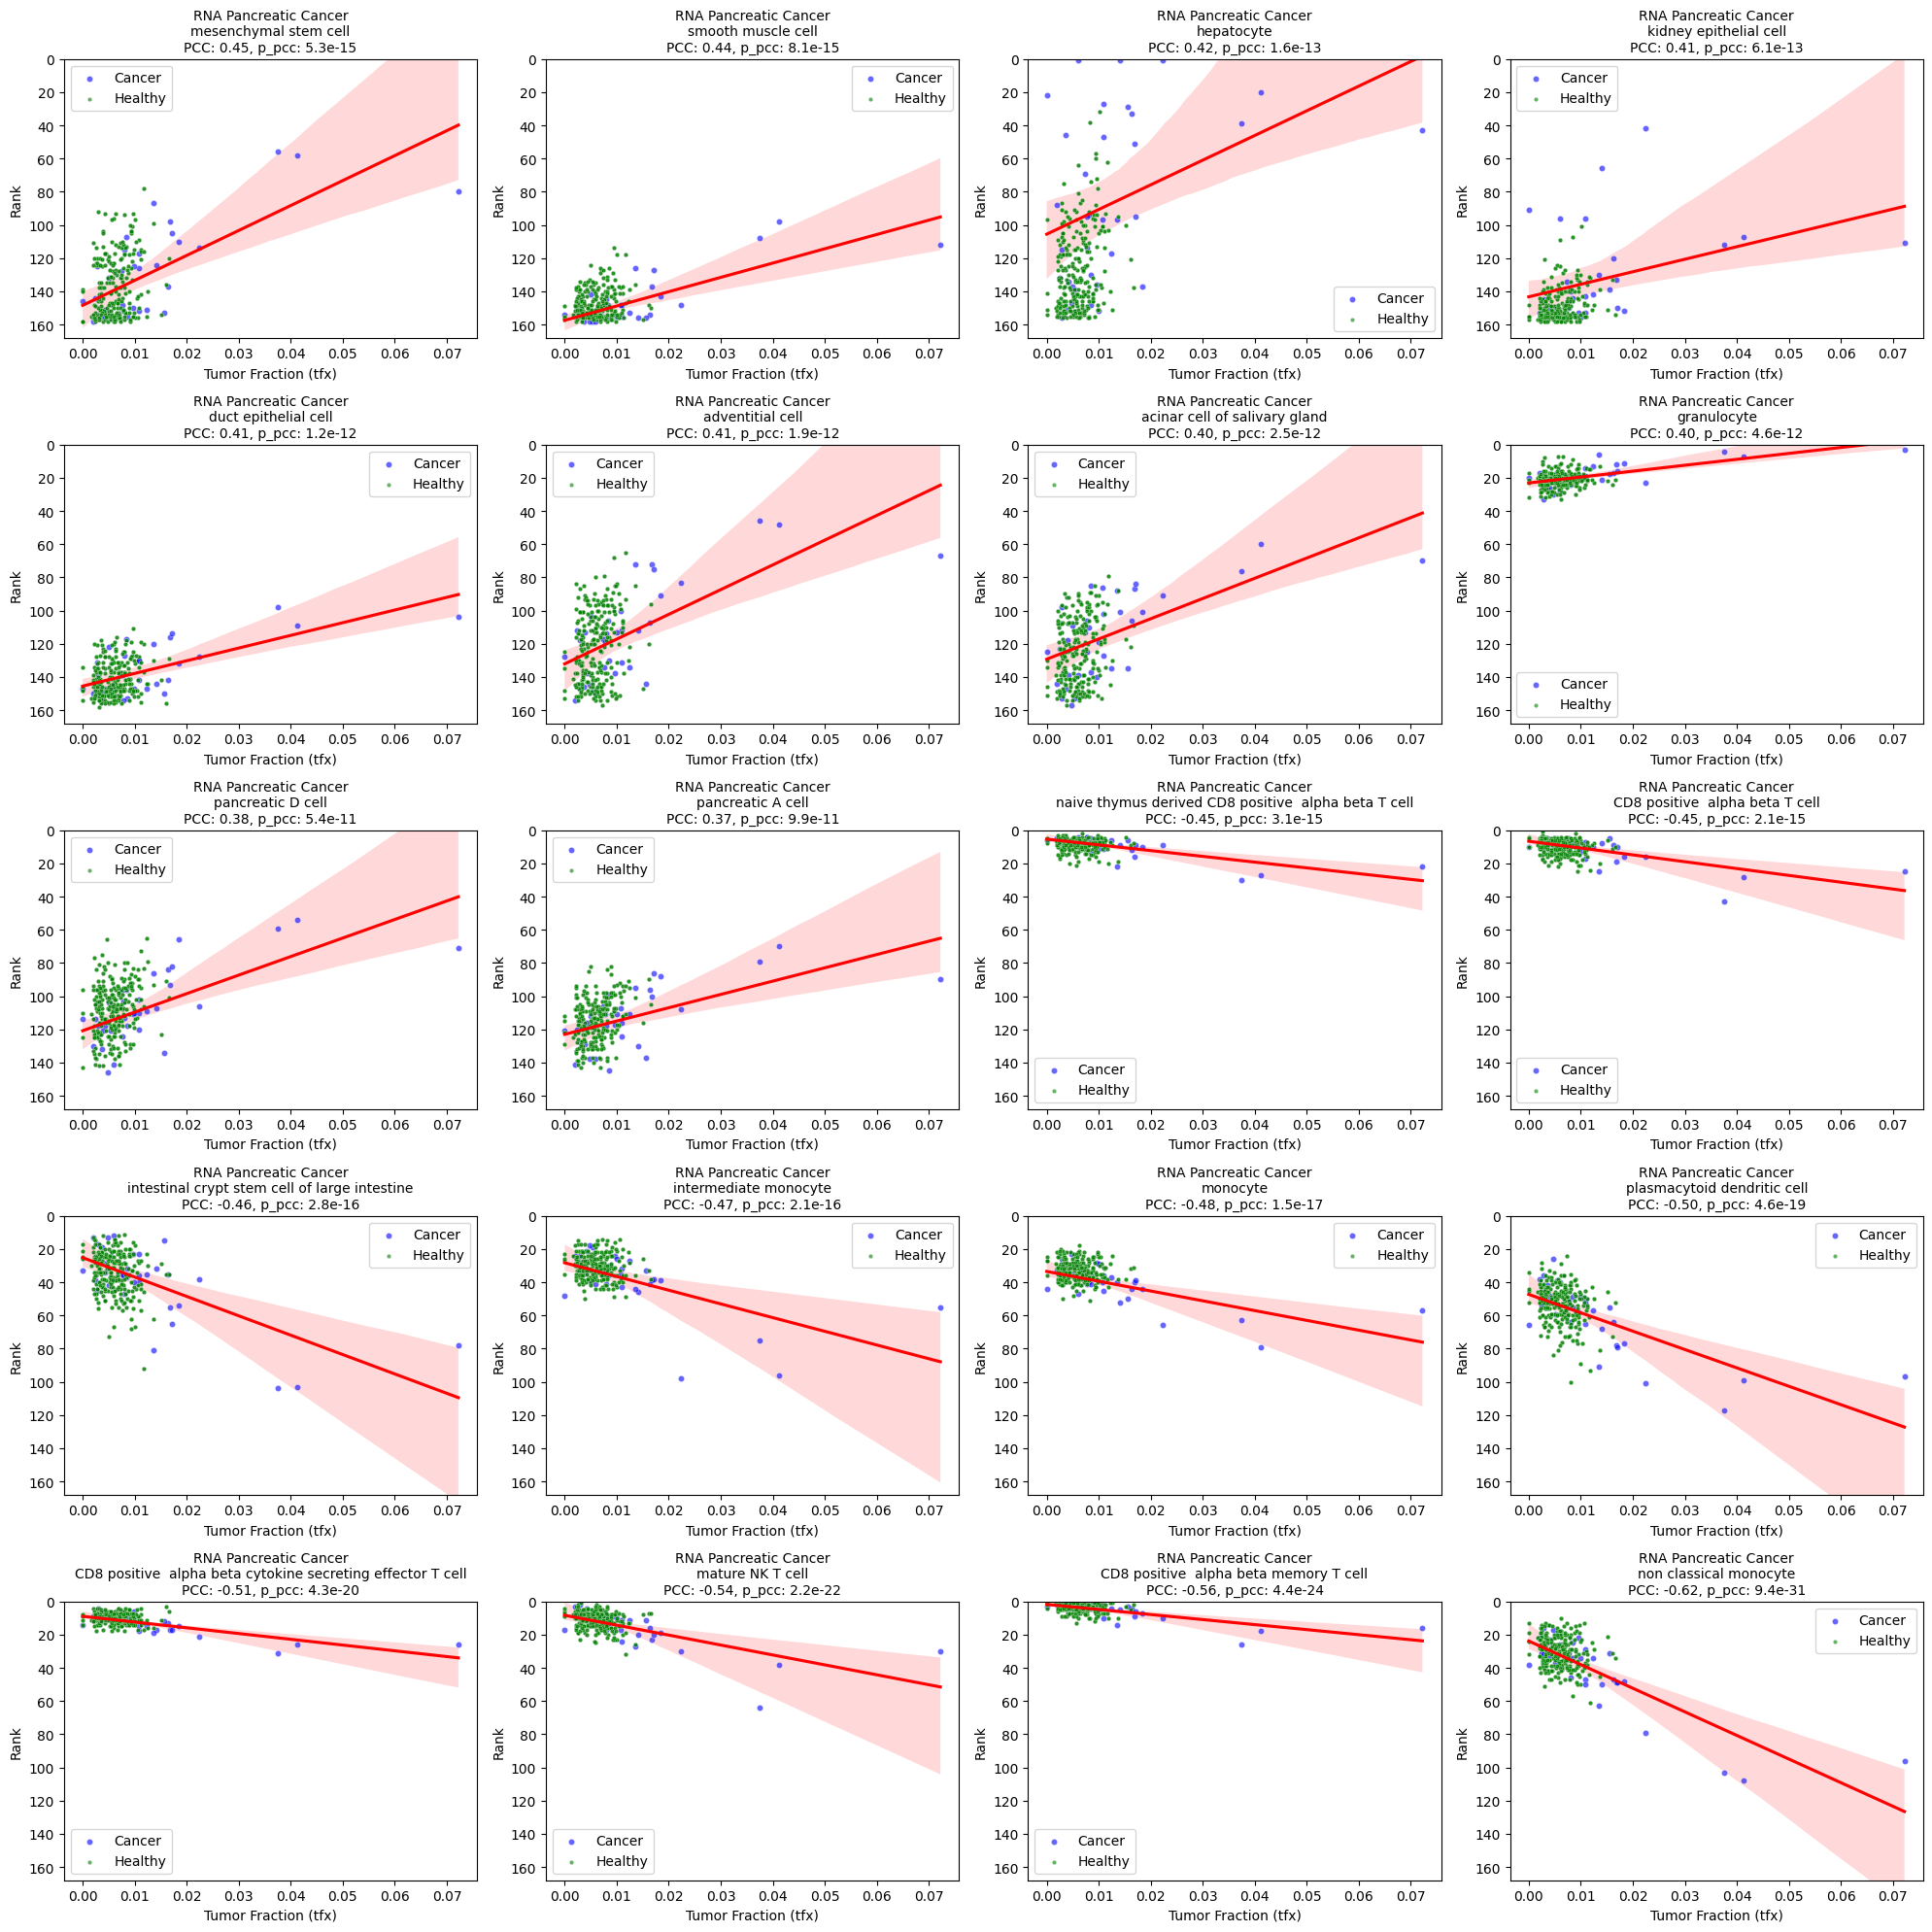

Ovarian Cancer


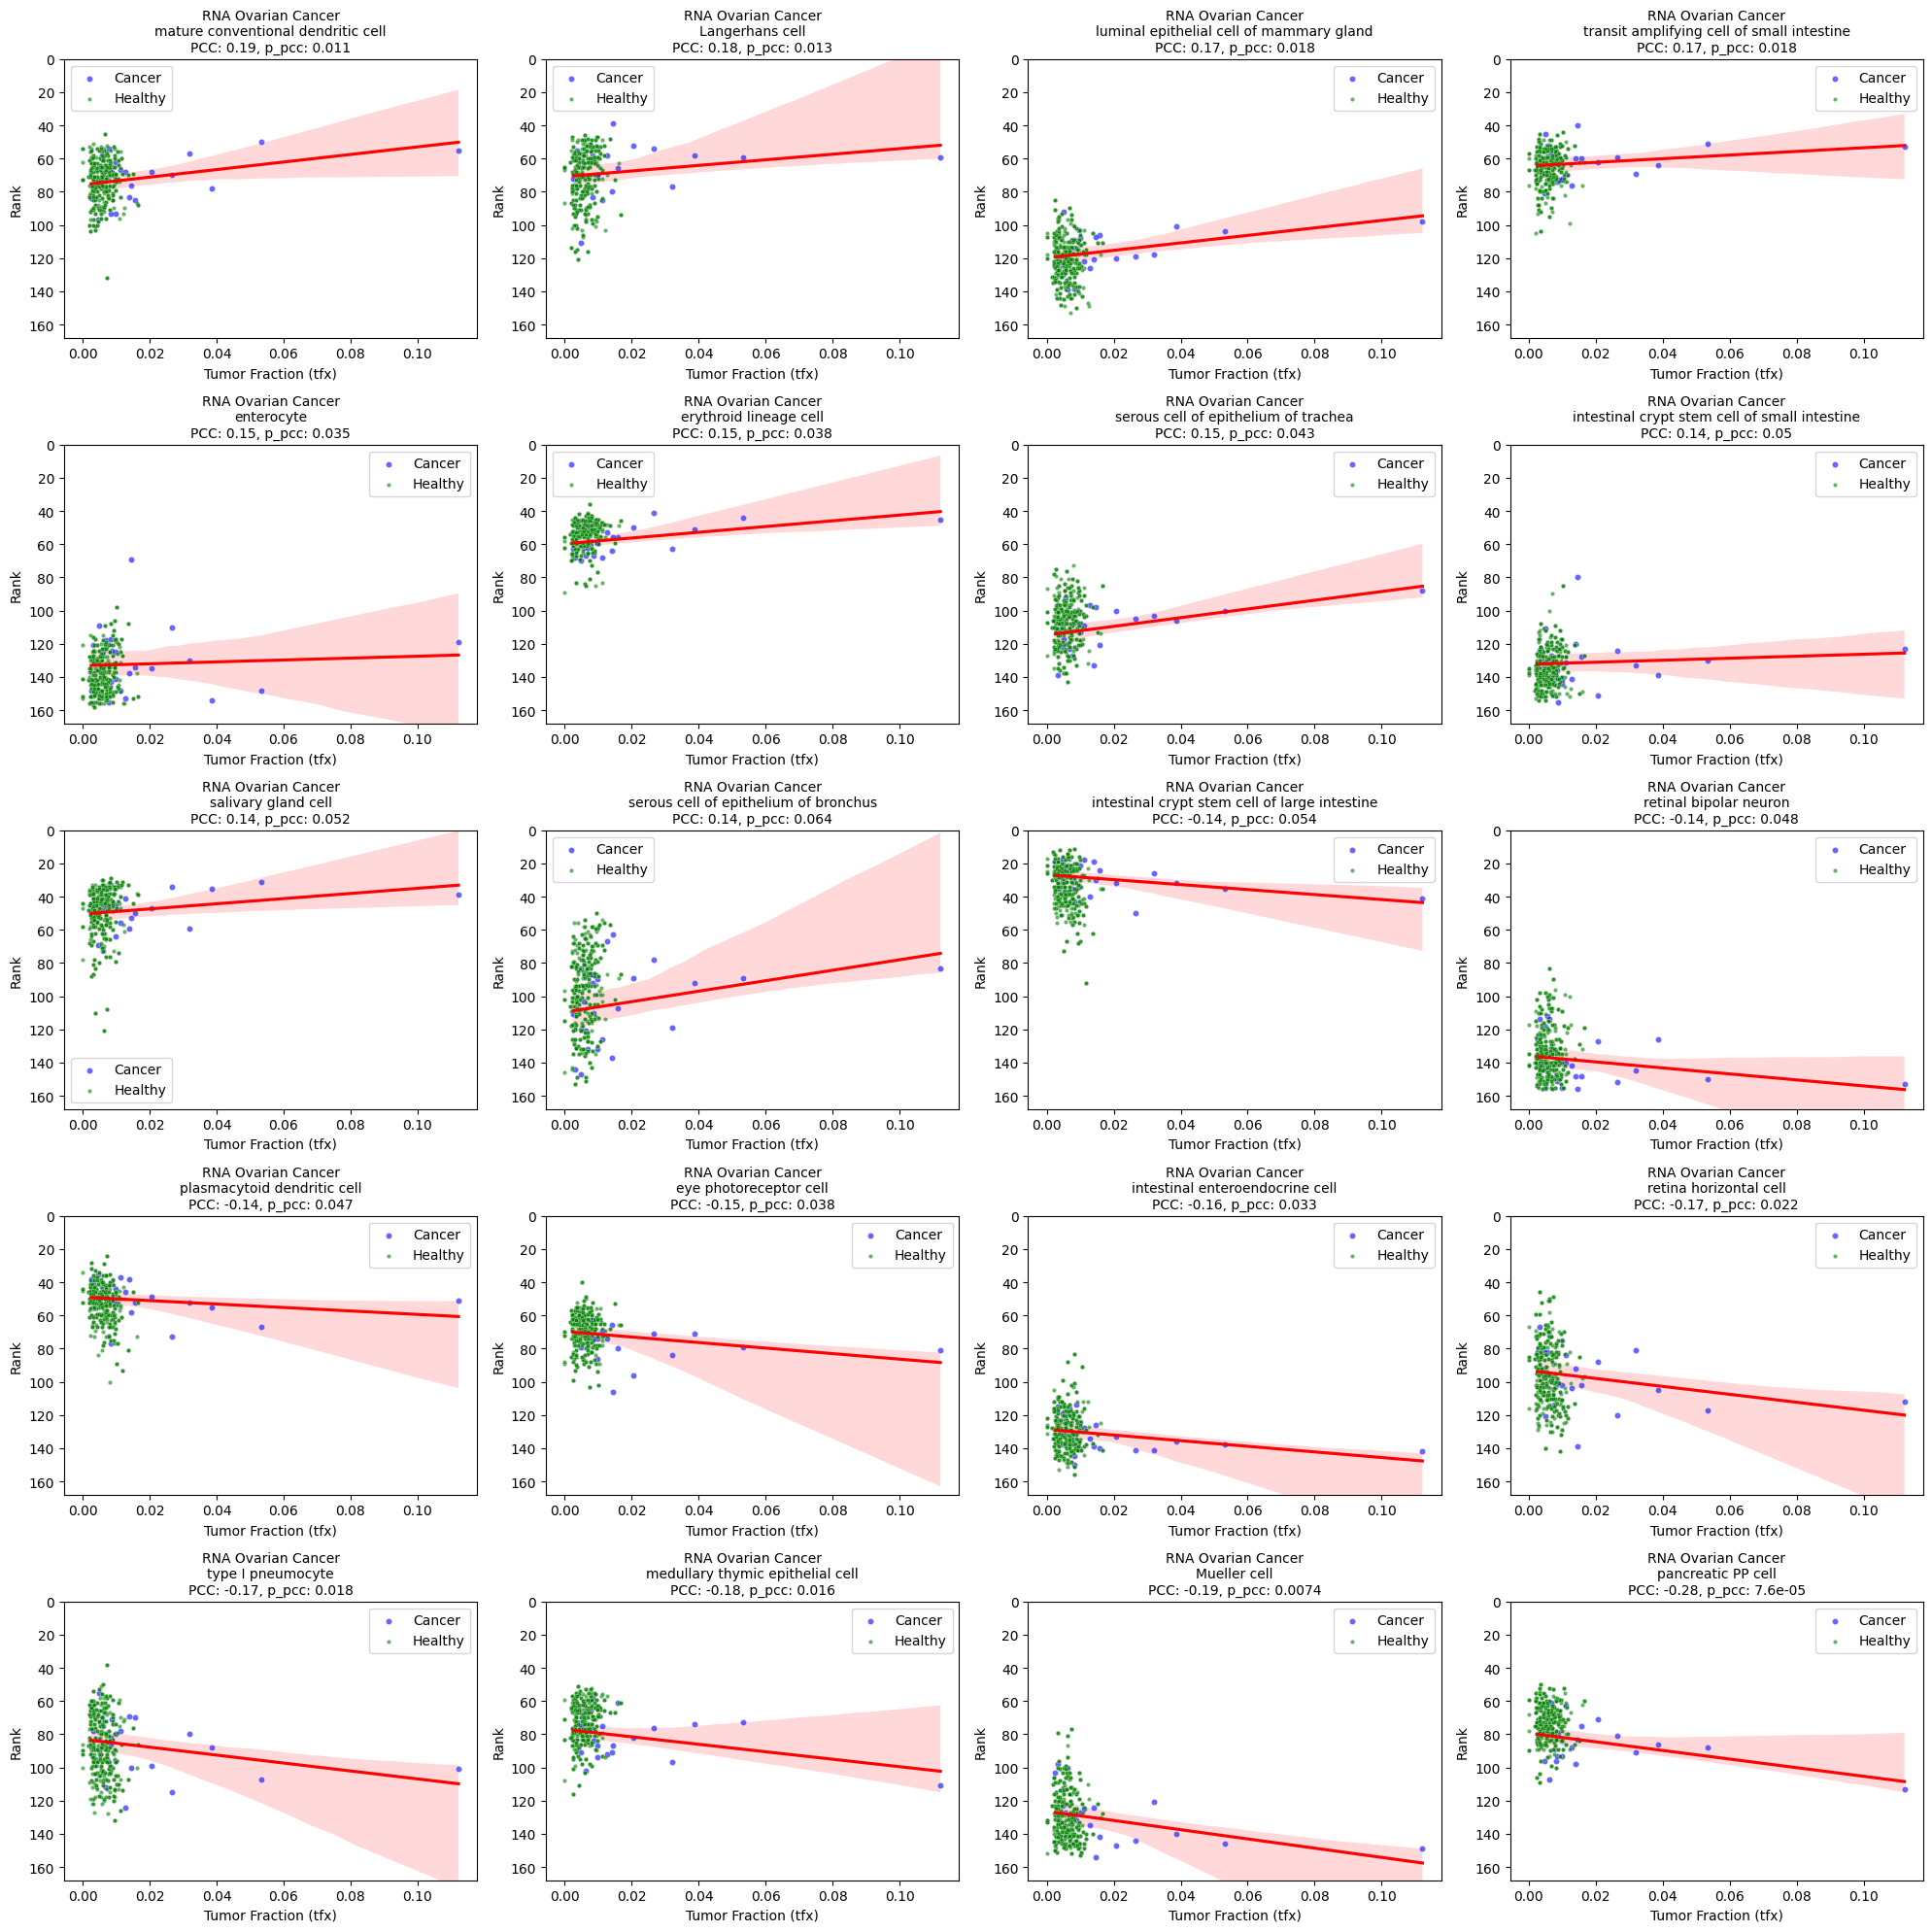

Bile Duct Cancer


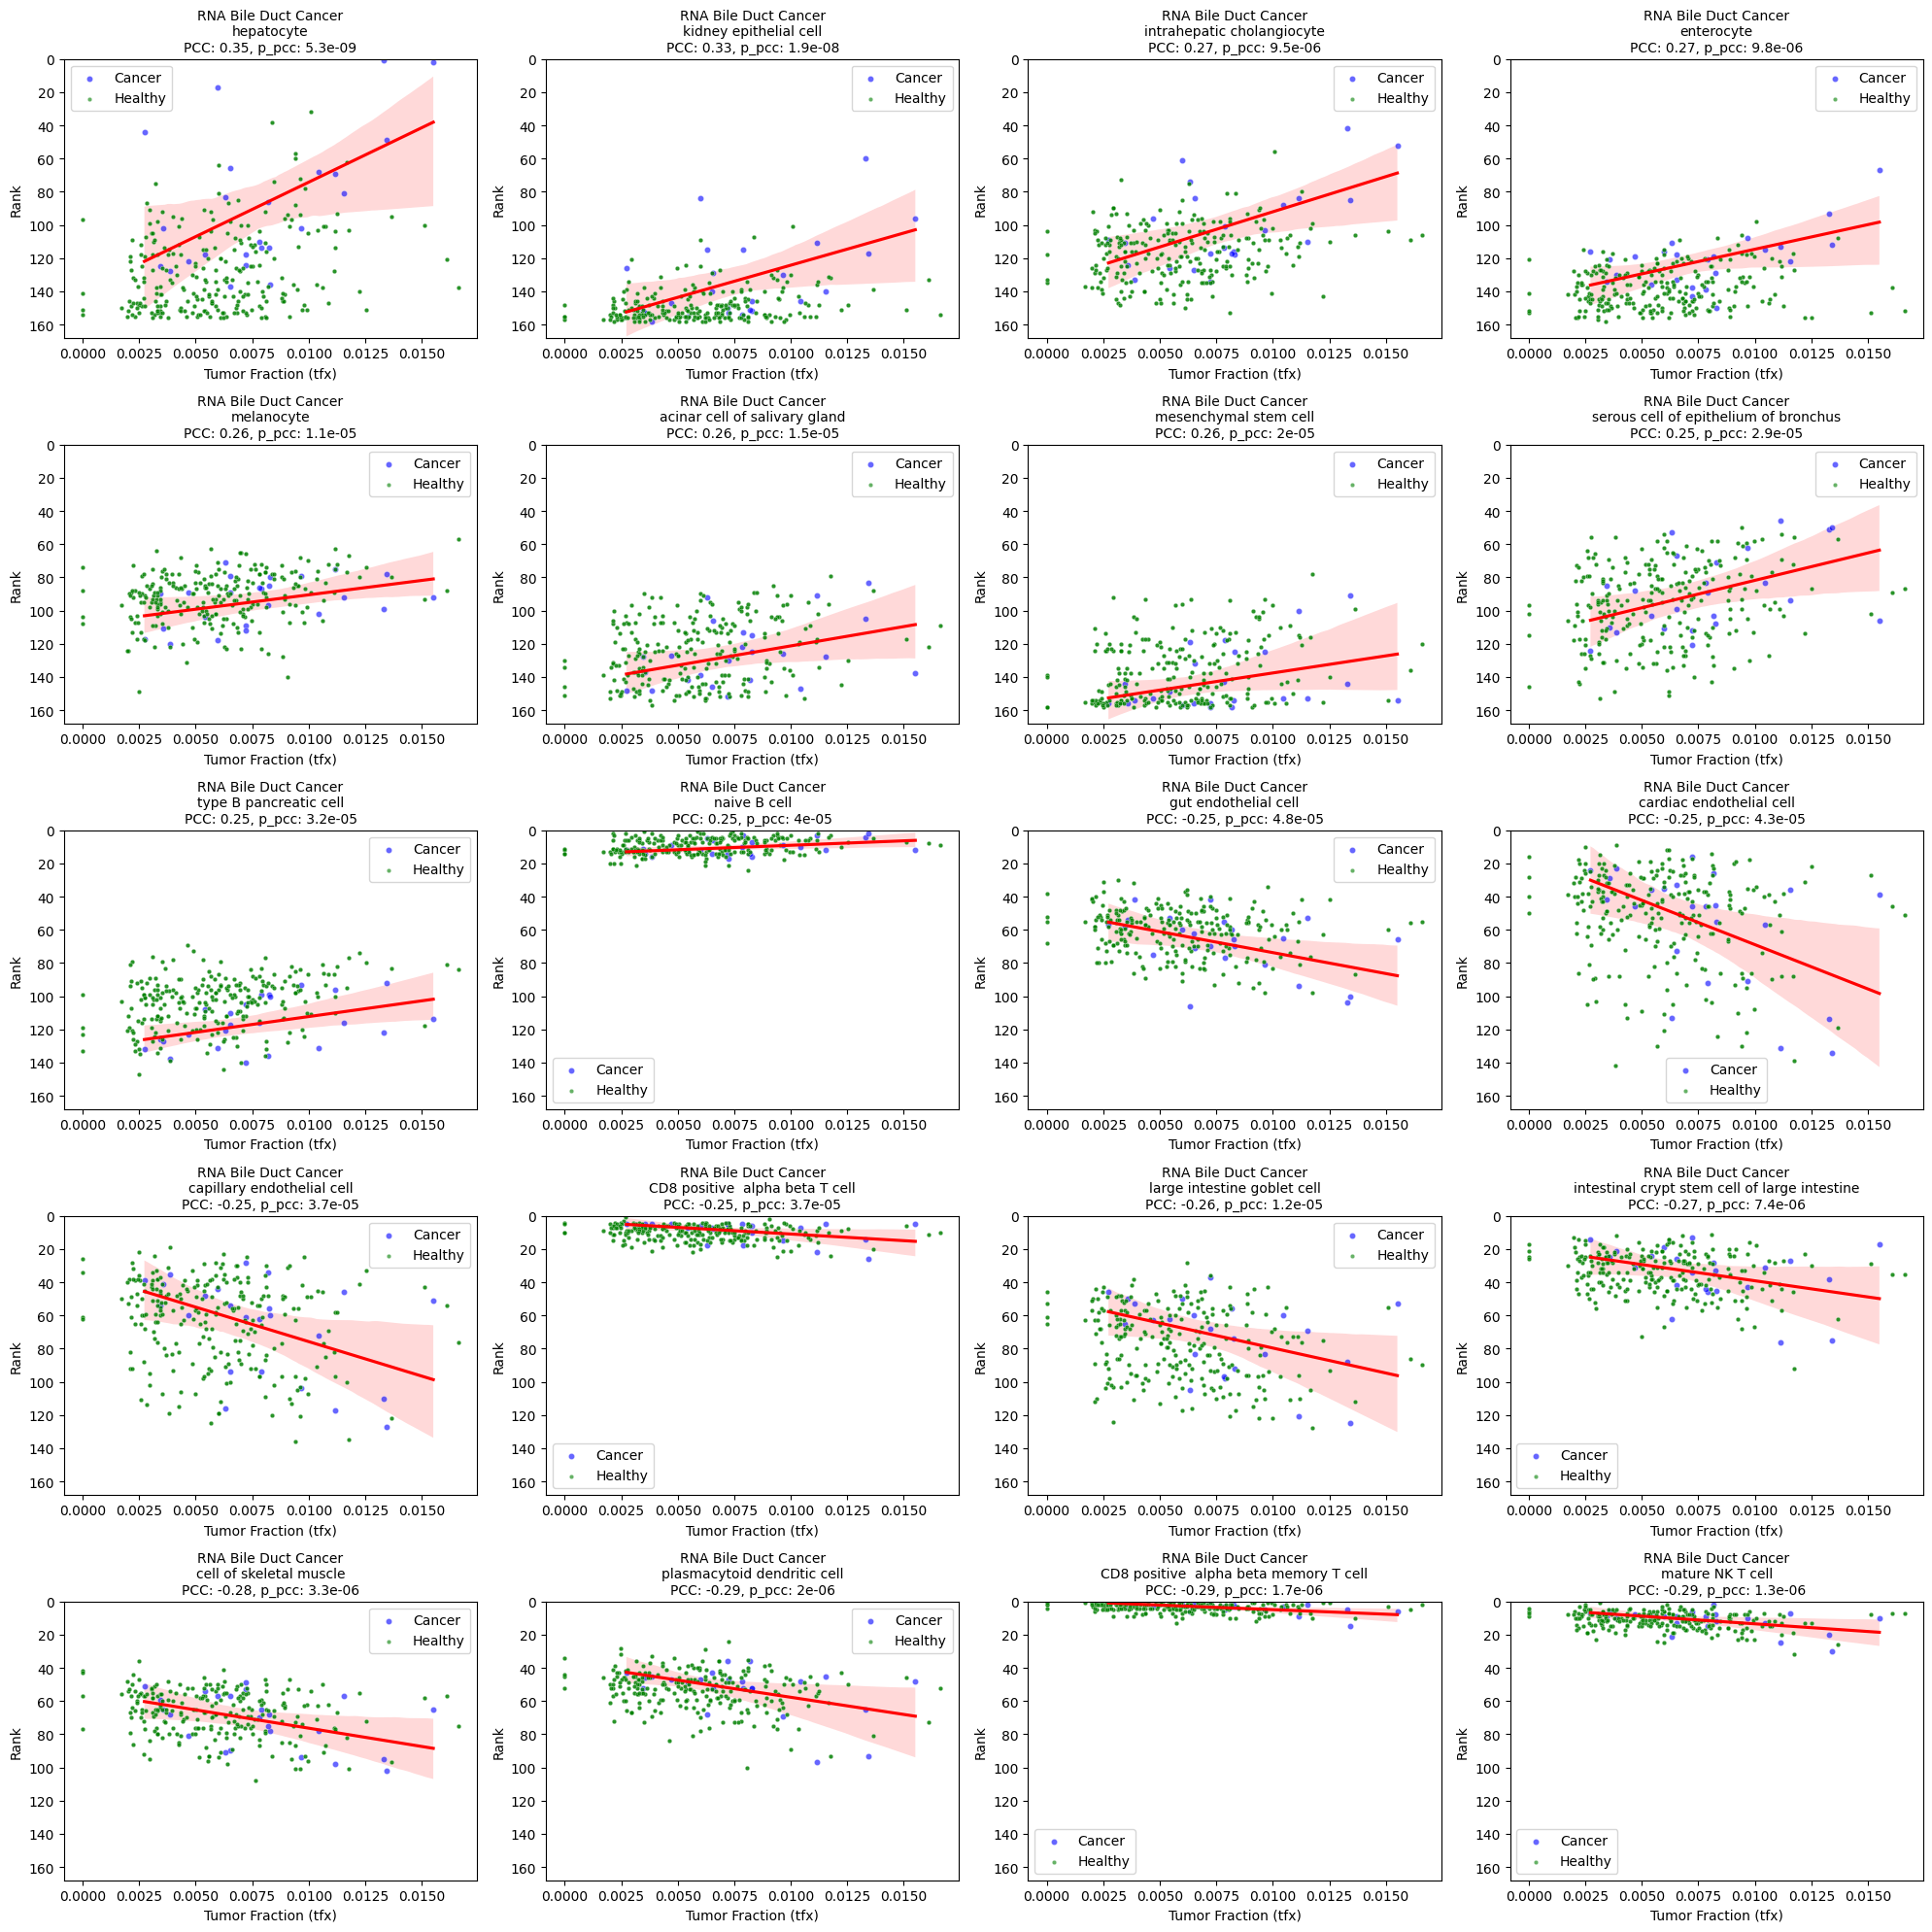

Colorectal Cancer


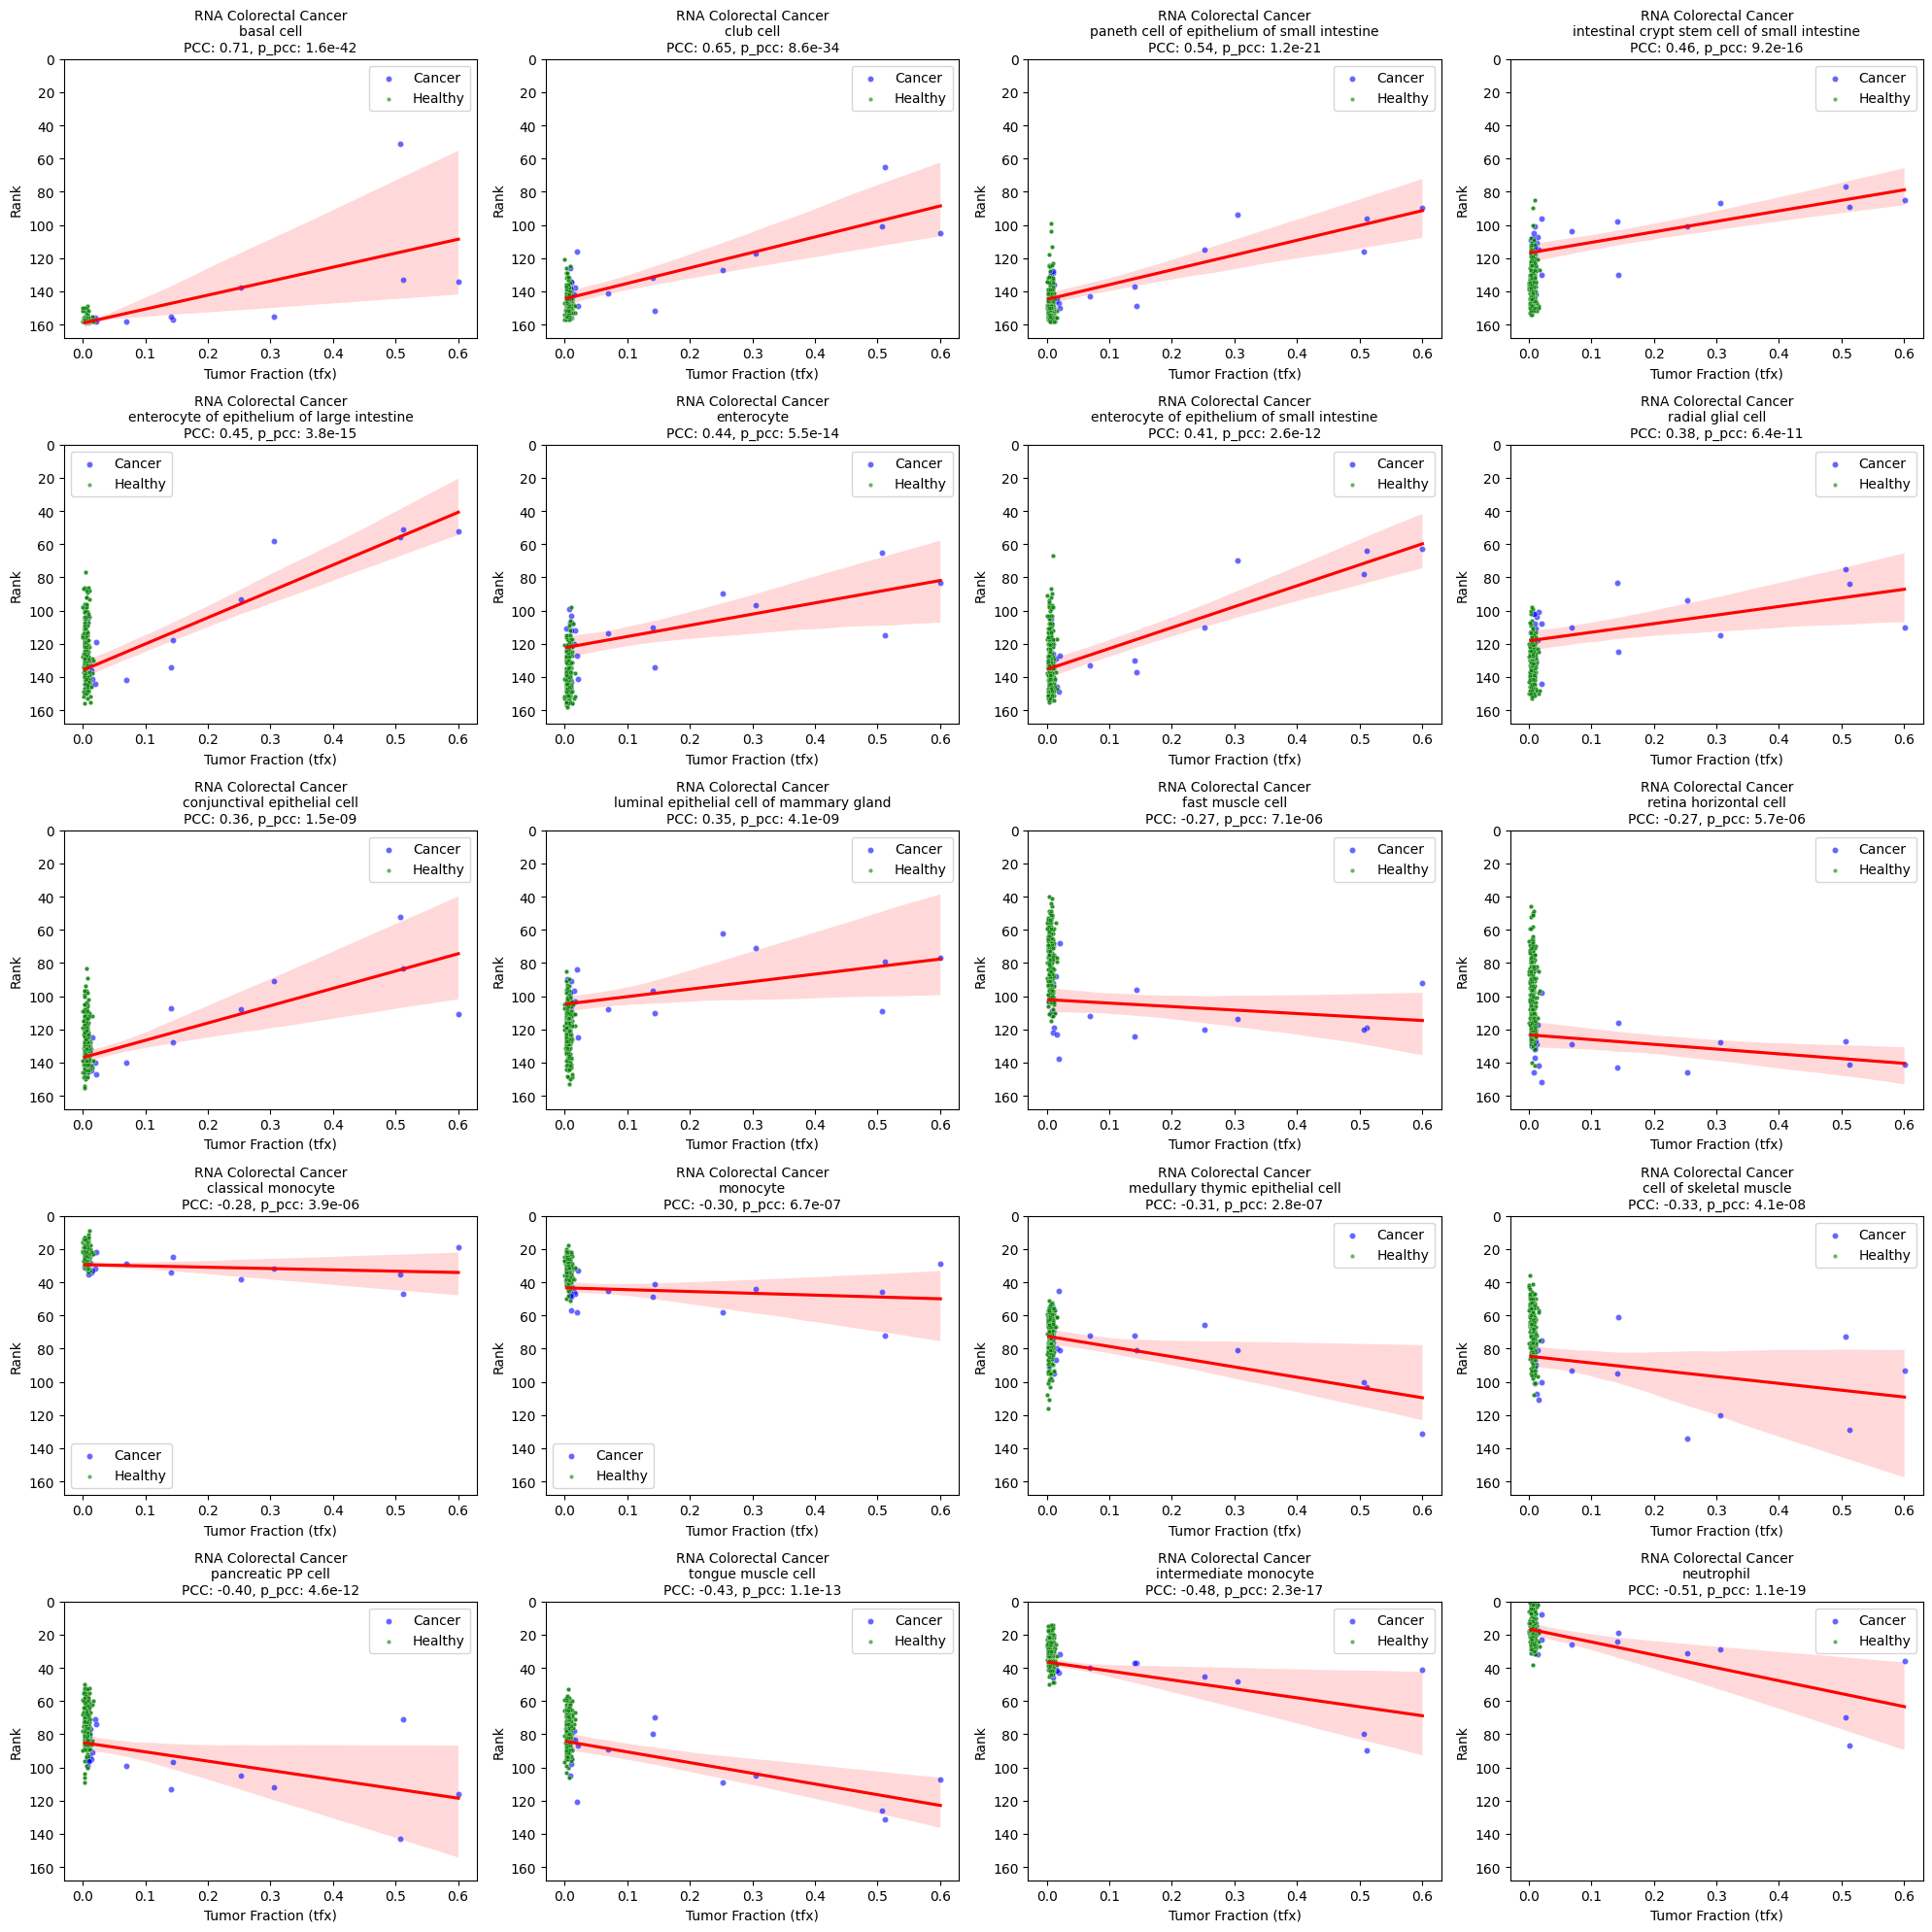

Gastric cancer


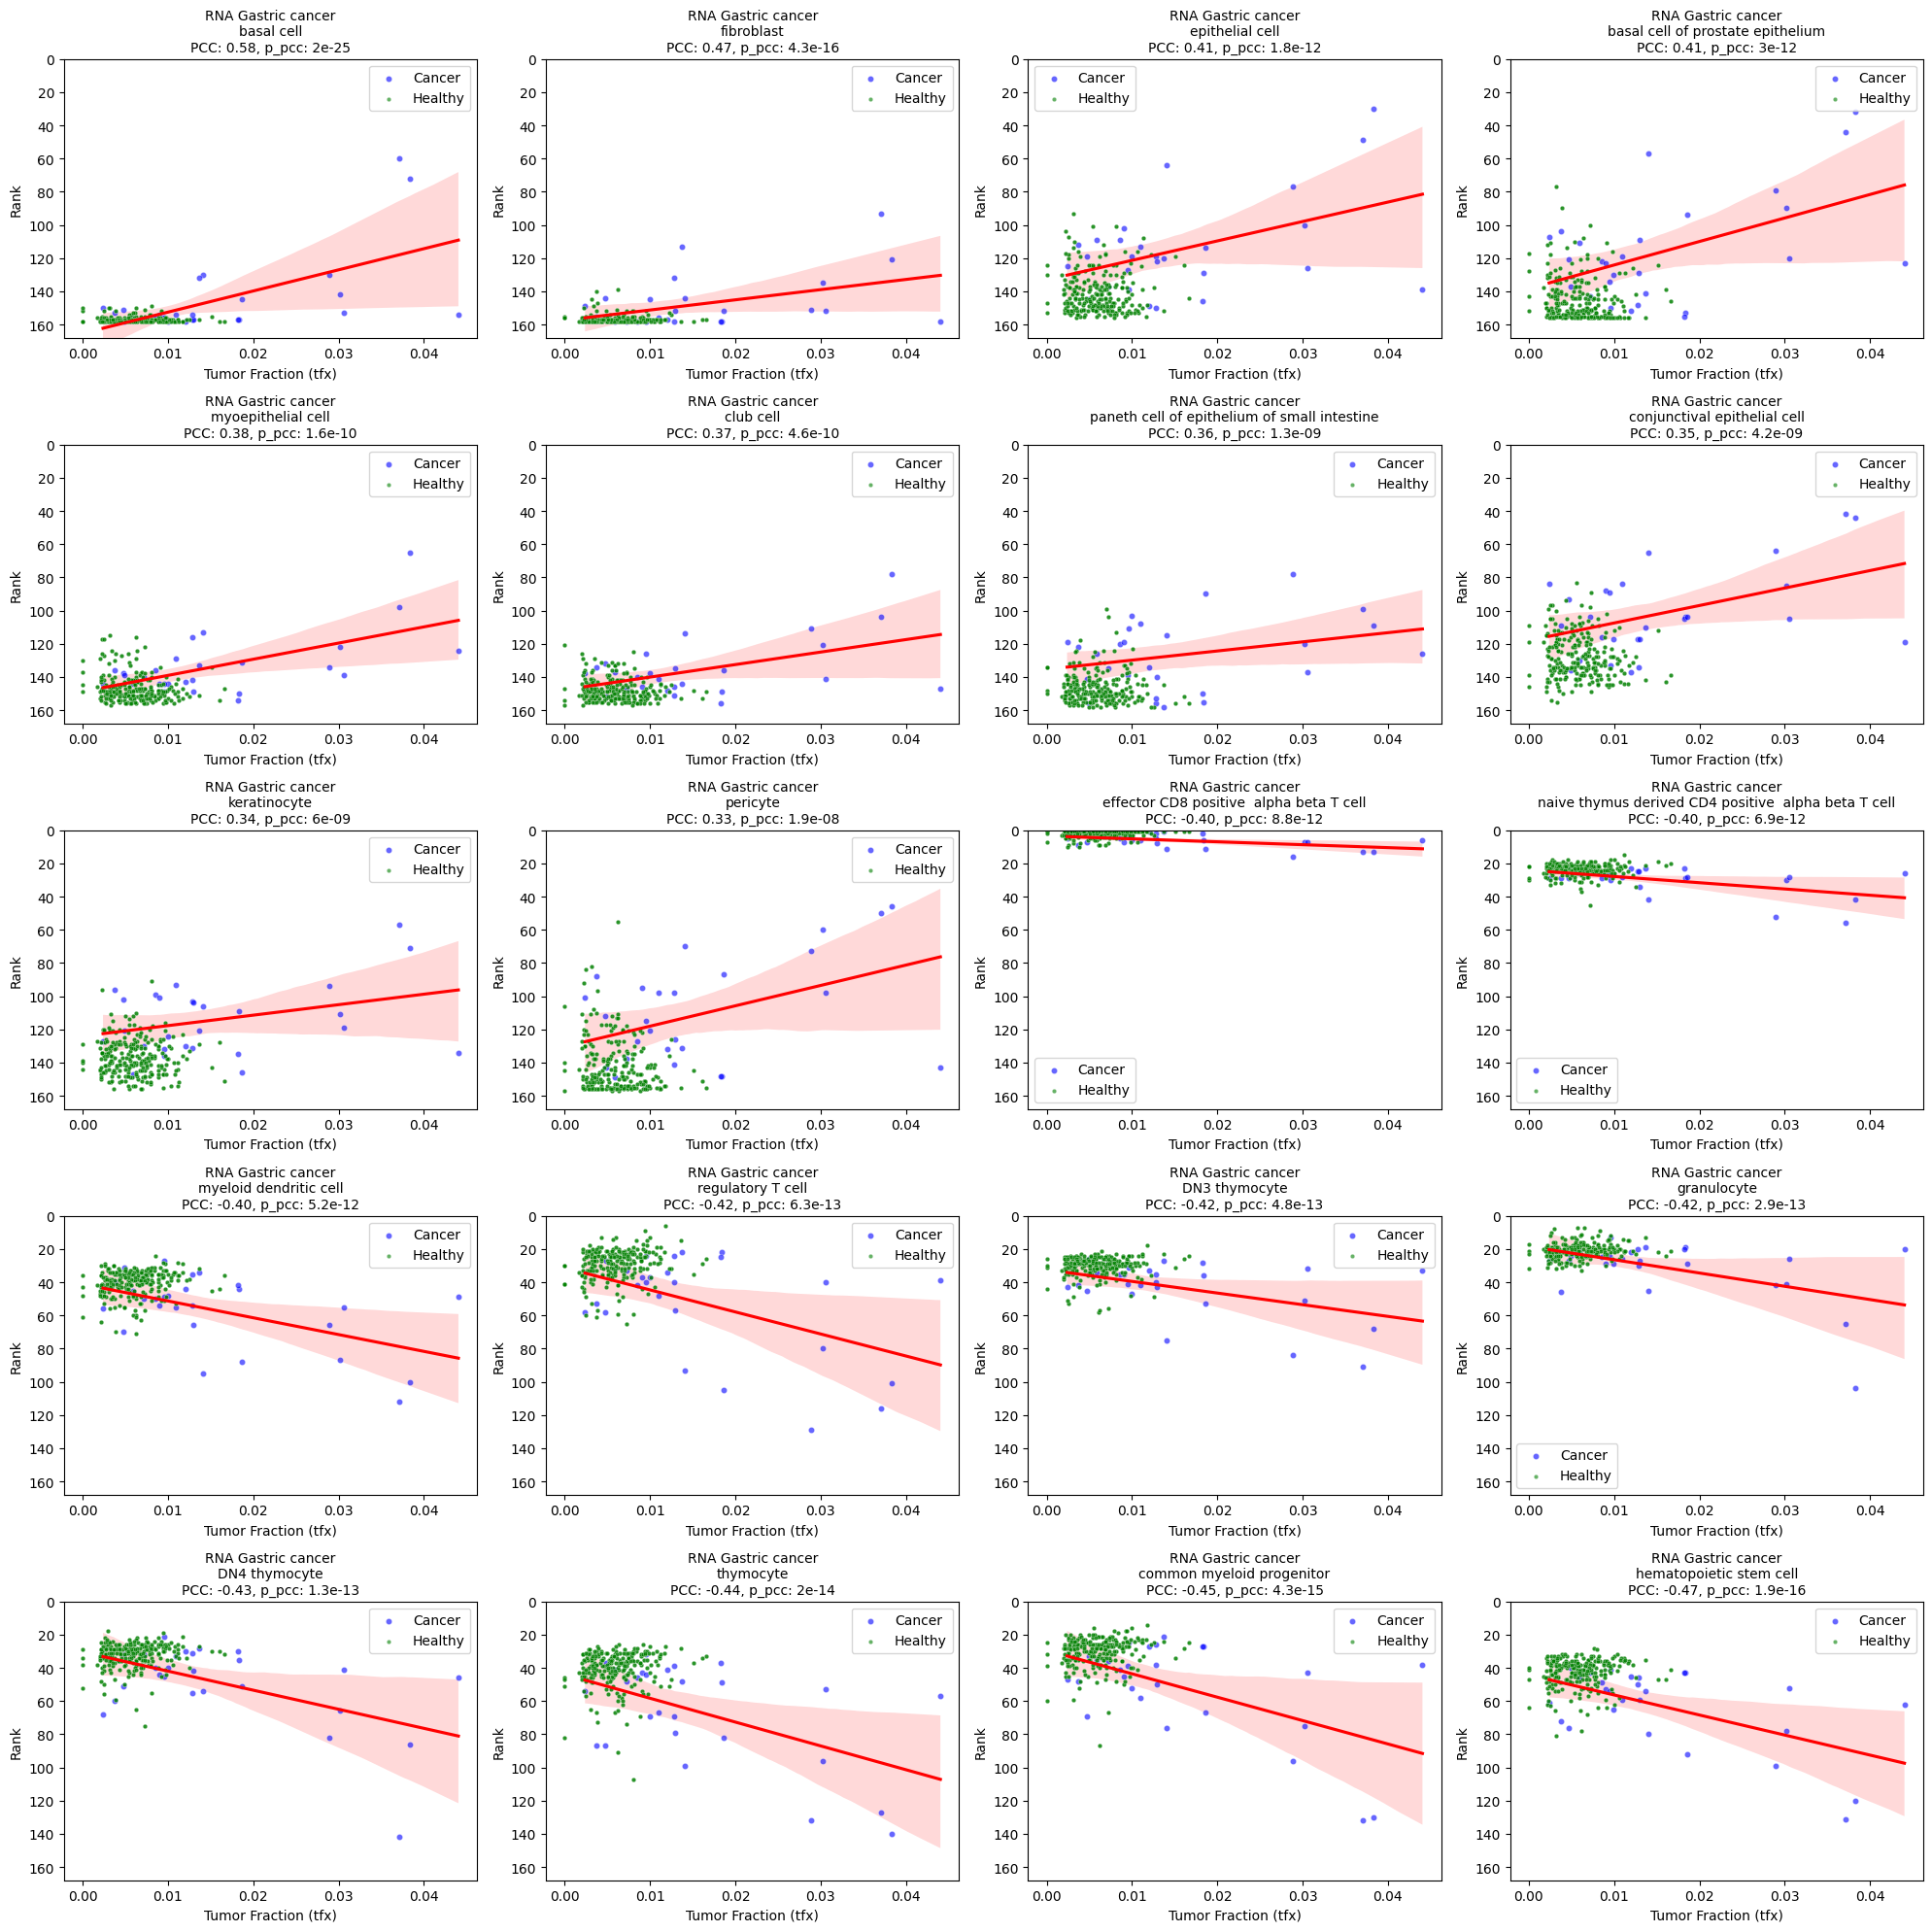